## **ANÁLISIS DEL TIPO DE CAMBIO EURO/PESO MEXICANO (EUR/MXN) DE LOS ÚLTIMOS 10 AÑOS**

In [13]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning) #ignorar warnings para tener salidas mas claras
import pandas as pd #Dataframes
import numpy as np #Operaciones numericas
import matplotlib.pyplot as plt #Graficos
from sklearn.preprocessing import PowerTransformer #Transformacion Box-Cox
from statsmodels.tsa.arima.model import ARIMA #Ajuste ARIMA
import yfinance as yf #Descargar datos desde yahoo finance
from statsmodels.tsa.stattools import acf, pacf #calculo del ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Graficos del ACF y PACF
from statsmodels.stats.diagnostic import acorr_ljungbox #prueba ljung-box
import seaborn as sns #otros graficos
from scipy.stats import norm #generar numeros de una distribucion normal
from scipy.stats import t #generar numeros de una distribucion t
from numpy.random import uniform #generar numeros de una distribucion uniforme
import statsmodels.api as sm #para regresion lineal
from statsmodels.stats.diagnostic import het_arch #prueba de heterocedasticidad arch
from arch import arch_model #Ajuste ARCH y GARCH
import scipy.stats as scs 
from datetime import datetime, timedelta #para fechas y diferencia entre fechas
plt.style.use('ggplot')

#### **Introducción y contexto de la serie**

La serie de tiempo del tipo de cambio Euro/Peso Mexicano es una serie que muestra la evolución del precio en Pesos Mexicanos necesarios para comprar o vender un Euro, dicho tipo de cambio se ofrece en el mercado de divisas. Durante los últimos 10 años, la serie ha tenido algunos principales comportamientos: 
 
 * **Antes de la pandemia**, el precio por Euro oscilaba alrededor de los 20 a 23 MXN, con ciertos periodos de alza y ciertos periodos de baja relativamente común en las divisas. 
 * **Al comenzar la pandemia**, el precio fue muy volátil, pasando de 21 MXN por Euro a inicios de marzo del 2020, a casi 27 MXN por Euro a inicios de abril del 2020, esto debido a que el Euro se consideraba una divisa fuerte frente a otras en ese momento de crisis, por lo que era una divisa muy demandada.
 * **Durante la pandemia**, entre marzo 2020 y marzo 2022, el precio se mantuvo alto, alrededor de 24 a 26 EUR/MXN, debido a la incertidumbre global derivada de la crisis sanitaria, lo cual seguía manteniendo al Euro como una divisa fuerte frente a otras. 
 * **A inicios del fin de la pandemia**, en abril de 2022, a serie comienza a estabilizarse en precios más bajos, incluso alcanzando valores entre 18 y 20 EUR/MXN en 2023 e inicios de 2024. 
 * **Actualmente**, la divisa ha estado teniendo una tendencia creciente desde mediados del 2024, manteniendo valores entre 20 y 22 EUR/MXN, debido principalmente al cambio de gobierno y politicas monetarias en México, así como la estabilidad económica de Europa en estos últimos meses. 

[*********************100%***********************]  1 of 1 completed


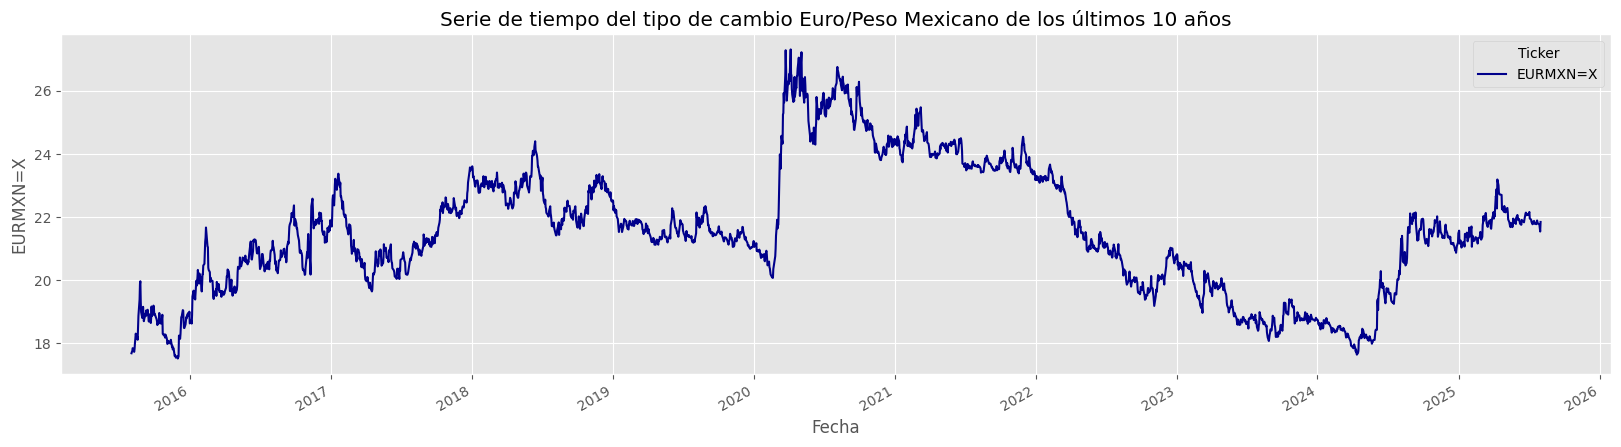

Ticker,EURMXN=X
Date,
2015-08-03,17.675840
2015-08-04,17.717470
2015-08-05,17.735291
2015-08-06,17.836029
2015-08-07,17.829000
...,...
2025-07-28,21.761999
2025-07-29,21.752100
2025-07-30,21.652399


In [14]:
#descargamos la serie de tiempo del tipo de cambio EURO/MXN desde yahoo finance
Ticker = 'EURMXN=X'
serie = yf.download(Ticker, period='10y')['Close']

#grafico de precios
serie.plot(figsize=(20,5),color='darkblue')
plt.title('Serie de tiempo del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.ylabel(Ticker)
plt.show()

#dataframe de los precios
display(serie)

#### **Autocorrelogramas simples y parciales de la serie**

El ACF muestra una caída muy lenta y que sobrepasa de manera evidente las bandas de confianza, lo cual indica que la serie no es estacionaria, y esto lo podemos notar desde que la serie si presenta ciertos periodos de alza y baja muy drásticos. Por otro lado, el PACF muestra una correlación significativa, por lo que para esta serie el valor del precio de hoy influye demasiado en el valor del precio siguiente.

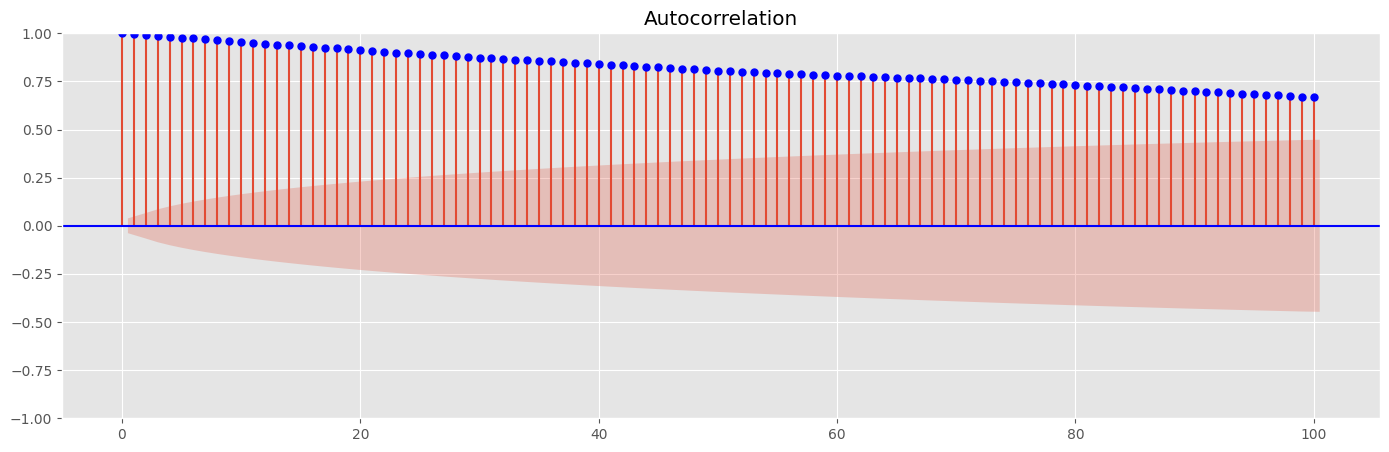

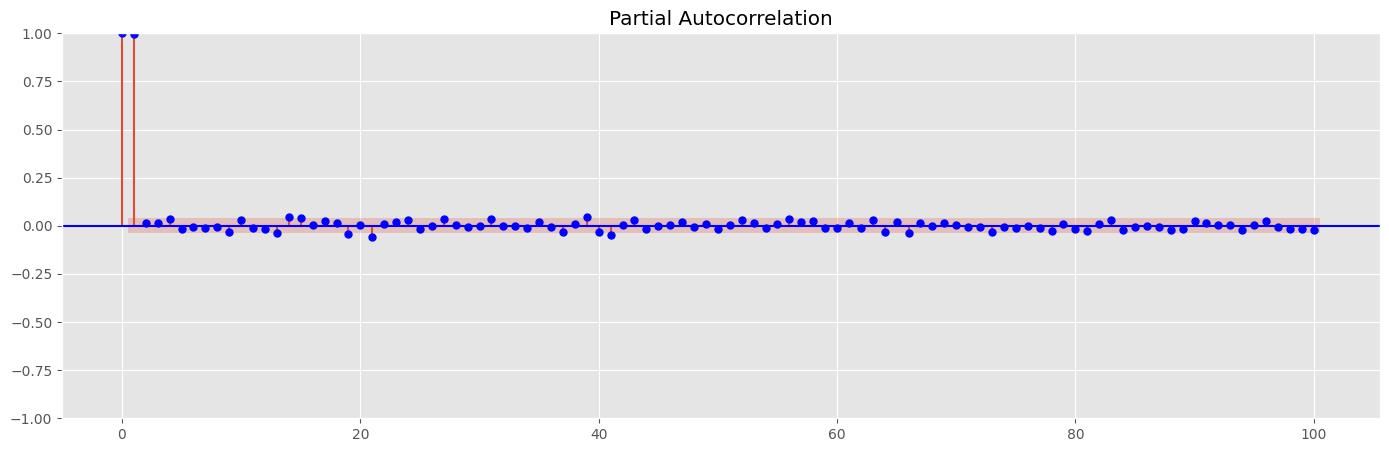

,ACF,PACF
0,1.000000,1.000000
1,0.995204,0.995586
2,0.990560,0.014625
3,0.986078,0.016150
4,0.981954,0.039068
5,0.977662,-0.019791
6,0.973333,-0.005552
7,0.968901,-0.013411
8,0.964463,-0.005143
9,0.959761,-0.032996


In [15]:
#Autocorrelogramas simple y parcial de la serie de tiempo del tipo de cambio EUR/MXN
lags = 100

#grafico de ACF
plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(serie,lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)

#grafico de PACF
fig = plot_pacf(serie,lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)
plt.show()

#construir dataframe con las autocorrelaciones simples y parciales ACF y PACF
ACF_PACF = pd.DataFrame([acf(serie,nlags=lags),\
                         pacf(serie,nlags=lags)]).transpose()
ACF_PACF.columns = ['ACF','PACF']
display(ACF_PACF.head(10))

#### **Transformación Box-Cox para estacionalizar la serie**

Podemos estacionar la serie mediante una transformación de tipo Box-Cox, ya que todos los valores son positivos. El lambda óptimo para esta serie es $\lambda = 0.06$. Dado que el valor es cercano a cero, en lugar de usar la transformación con este lambda podríamos considerar la transformación cuando $\lambda = 0$, la cual es $ln(X_t)$.

In [16]:
#Obtenemos el valor de lambda para la transformada boxcox
box_cox_transform = PowerTransformer(method='box-cox',standardize=True, copy=True).fit(serie[[Ticker]])

#lambda
print('lambda=',box_cox_transform.lambdas_)

lambda= [-0.33564042]


Al comparar la serie original $X_t$ con $ln(X_t)$, en primera instancia notamos que la serie transformada si se acota y parece estacionalizarse, sin embargo, reescalando notamos que seguimos teniendo los mismos cambios abruptos en algunos periodos de tiempo, solo que a una escala menor.

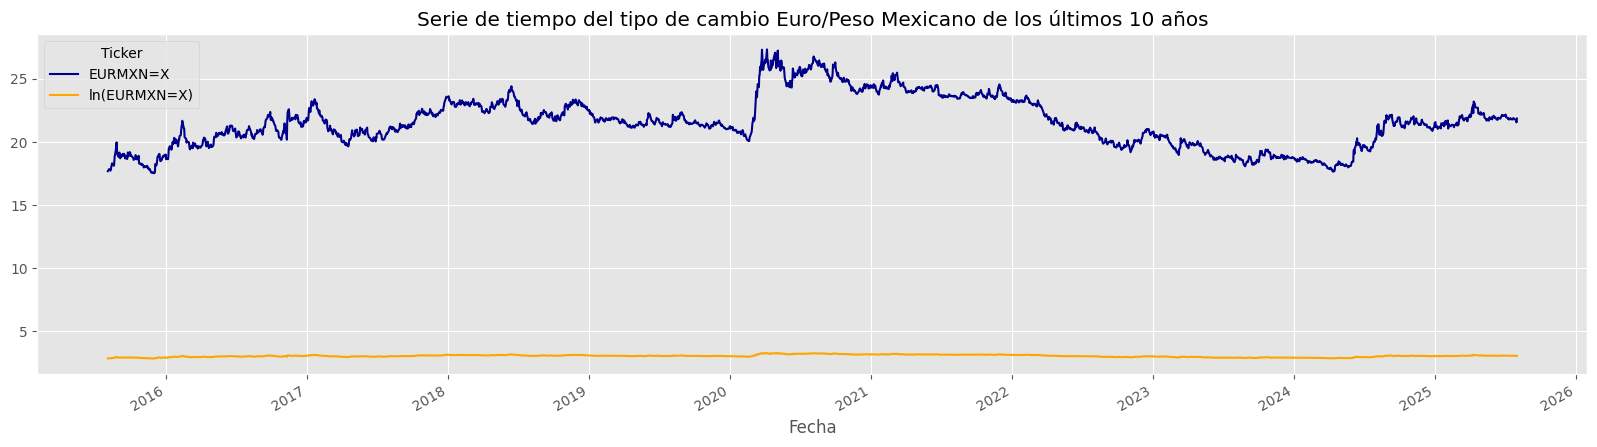

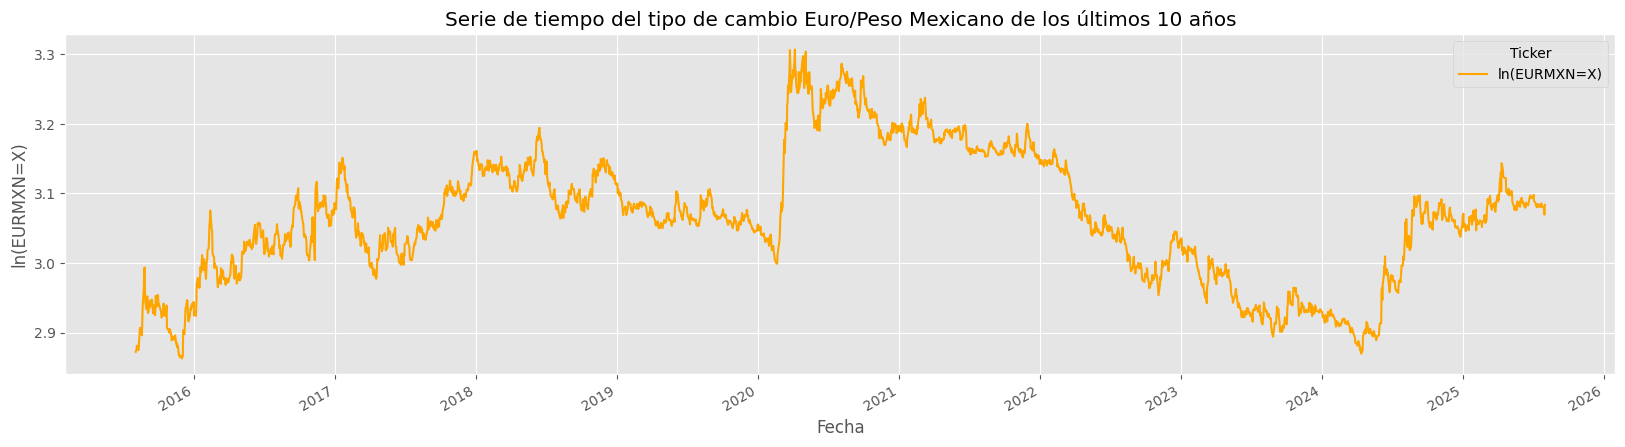

Ticker,EURMXN=X,ln(EURMXN=X)
Date,,
2015-08-03,17.675840,2.872199
2015-08-04,17.717470,2.874551
2015-08-05,17.735291,2.875556
2015-08-06,17.836029,2.881221
2015-08-07,17.829000,2.880826
...,...,...
2025-07-28,21.761999,3.080165
2025-07-29,21.752100,3.079710
2025-07-30,21.652399,3.075116


In [17]:
#agregamos la columna de la serie transformada con logaritmo natural
serie['ln('+Ticker+')'] = np.log(serie[Ticker])

#grafico de ambas series (sin y con transformada box-cox)
serie[[Ticker,'ln('+Ticker+')']].plot(figsize=(20,5),color=['darkblue','orange'])
plt.title('Serie de tiempo del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.show()

#grafico de la serie transformada
serie[['ln('+Ticker+')']].plot(figsize=(20,5),color=['orange'])
plt.title('Serie de tiempo del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.ylabel('ln('+Ticker+')')
plt.show()

#dataframe de la serie original y la transformada
display(serie)

#### **Retornos logarítmicos $r_t$**

Otra forma de estacionalizar la serie es obteniendo la primera diferencia de la serie transformada $ln(X_t)$, que en el contexto de las series de tiempo financieras, corresponden a los retornos de tipo logarítmicos, definidos como:

$$r_t = ln \left( \frac{X_t}{X_{t-1}} \right) = ln(X_t) - ln(X_{t-1})$$

Ticker,EURMXN=X,ln(EURMXN=X),B(ln(EURMXN=X),∇(ln(EURMXN=X))
Date,,,,
2015-08-03,17.675840,2.872199,NaN,NaN
2015-08-04,17.717470,2.874551,2.872199,0.002352
2015-08-05,17.735291,2.875556,2.874551,0.001005
2015-08-06,17.836029,2.881221,2.875556,0.005664
2015-08-07,17.829000,2.880826,2.881221,-0.000394
...,...,...,...,...
2025-07-28,21.761999,3.080165,3.081538,-0.001373
2025-07-29,21.752100,3.079710,3.080165,-0.000455
2025-07-30,21.652399,3.075116,3.079710,-0.004594


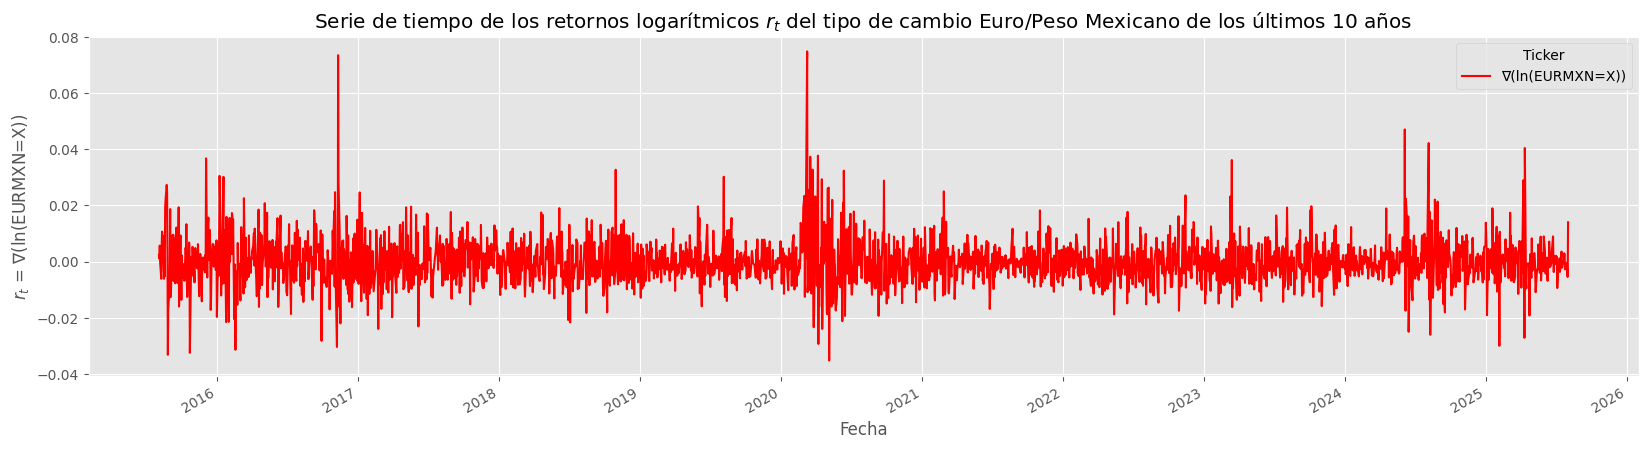

In [18]:
#Calcular la diferencia ∇ de la serie transformada, la serie resultante son los retornos logaritmicos 
serie['B(ln('+Ticker+')'] = serie['ln('+Ticker+')'].shift()
serie['∇(ln('+Ticker+'))'] = serie['ln('+Ticker+')']-serie['B(ln('+Ticker+')']
display(serie)

#Grafico de la serie de los retornos logaritmicos
serie[['∇(ln('+Ticker+'))']].plot(figsize=(20,5),color='red')
plt.title(r'Serie de tiempo de los retornos logarítmicos $r_{t}$ del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.ylabel(r'$r_{t}$ = ∇(ln('+Ticker+'))')
plt.show()

Se observa una mayor estabilidad alrededor del 0, estando la mayoría de los retornos entre -0.03 y 0.03, salvo los casos donde precisamente la serie cambio mucho de precio (por ejemplo en 2020). Para visualizar de mejor manera los intervalos en los que se acumulan la mayoría de los retornos, se grafica su histograma:

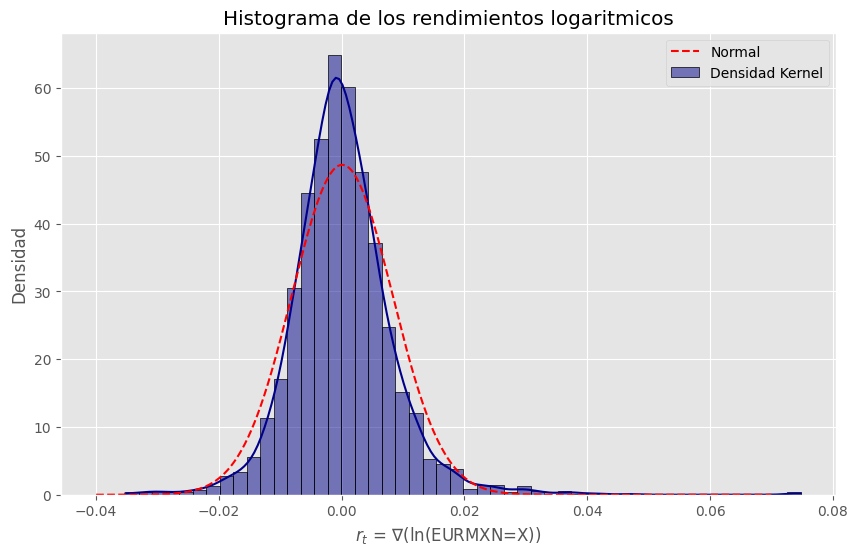

In [19]:
#Histograma y funcion de densidad kernel de los rendimientos logaritmicos
plt.figure(figsize=(10, 6))
sns.histplot(serie['∇(ln('+Ticker+'))'], bins=50, kde=True, stat="density", color='darkblue', edgecolor='black', label='Densidad Kernel')
plt.title(f'Histograma de los rendimientos logaritmicos')
plt.xlabel(r'$r_{t}$ = ∇(ln('+Ticker+'))')
plt.ylabel('Densidad')

#comparativo con una normal con media y desviacion estandar de los rendimientos logaritmicos
x = np.linspace(-0.04, 0.07, 3000)
plt.plot(x,norm.pdf(x, loc=np.mean(serie['∇(ln('+Ticker+'))']),scale=np.std(serie['∇(ln('+Ticker+'))'])),color='red',linestyle='--',label='Normal')

plt.legend()
plt.show()

Se observa que la distribución de los retornos sigue una distribución más leptocúrtica y de colas pesadas, sobre todo en la cola derecha correspondiente a los retornos positivos, esto debido principalmente al rápido crecimiento de la serie durante 2020. Si lo comparamos con una normal con media y desviación estándar muestrales de los retornos, se observa que está distribución no es la más adecuada, debido a que los retornos tienen una mayor concentración en el centro y además, hay más valores extremos que los que una normal capturaría.

#### **Autocorrelogramas simples y parciales de la serie de retornos $r_t$**

Tanto en el ACF como en el PACF, se observa que los retornos no están correlacionados entre sí, es decir, que no basta con saber cuál es el retorno de hoy para poder predecir el de mañana. Esto es principalmente porque en las series de tiempo financieras, los precios se actualizan rápidamente con la nueva información disponible, la cual es completamente incierta (como eventos catastróficos, políticos, etc.).

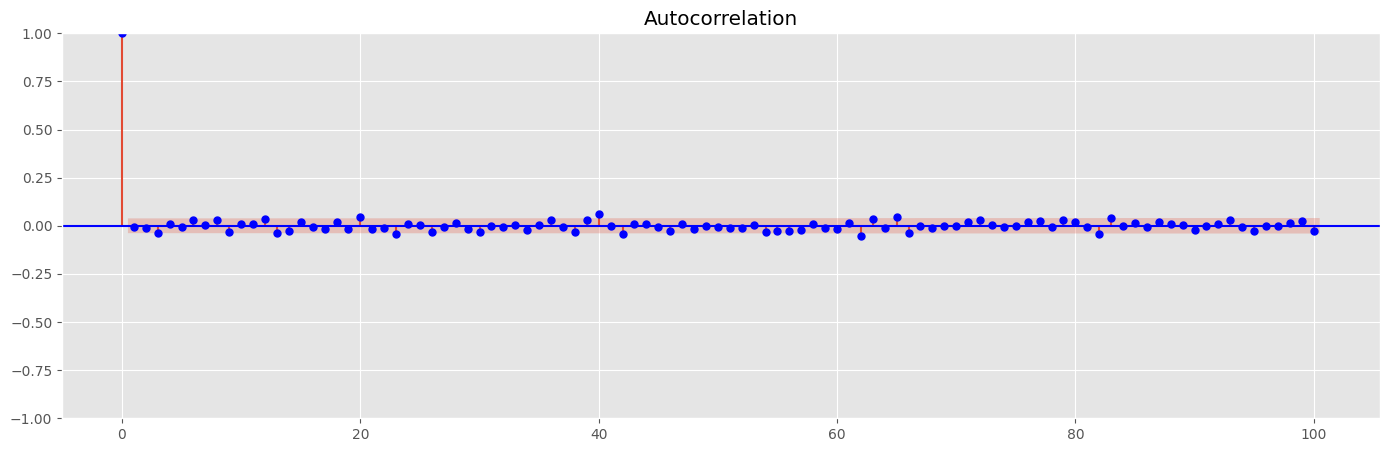

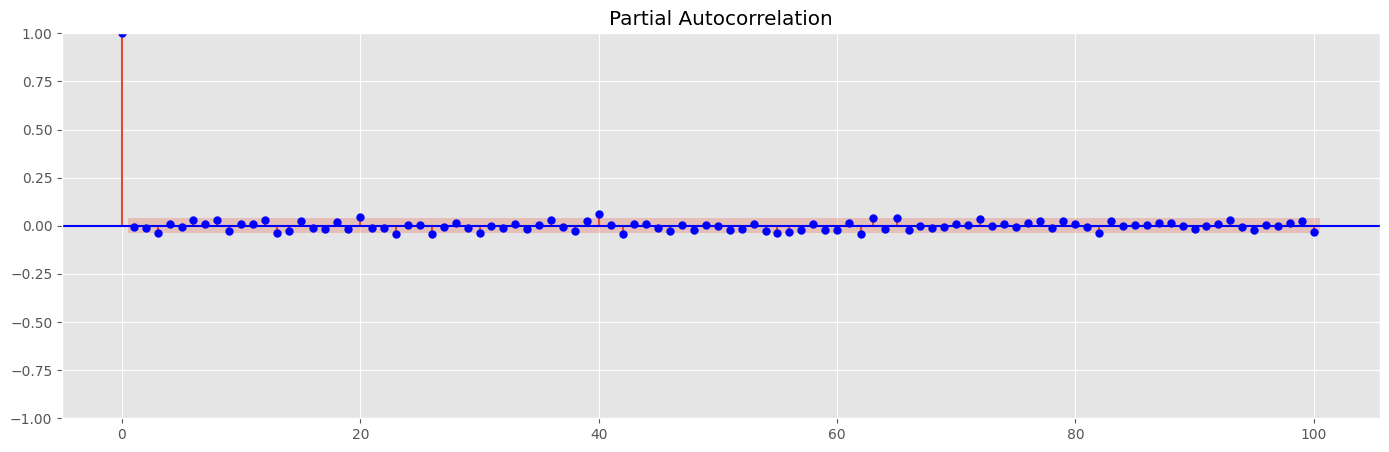

,ACF,PACF
0,1.000000,1.000000
1,-0.006035,-0.006037
2,-0.011703,-0.011749
3,-0.038324,-0.038517
4,0.007497,0.006895
5,-0.006894,-0.007739
6,0.032246,0.030977
7,0.005936,0.006735
8,0.028774,0.029183
9,-0.031378,-0.028565


In [20]:
#Autocorrelogramas simple y parcial de los retornos logaritmicos
lags = 100 

#grafico de ACF
plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(serie['∇(ln('+Ticker+'))'].iloc[1:],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)

#grafico de PACF
fig = plot_pacf(serie['∇(ln('+Ticker+'))'].iloc[1:],lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)
plt.show()

#construir dataframe con las autocorrelaciones simples y parciales ACF y PACF
ACF_PACF = pd.DataFrame([acf(serie['∇(ln('+Ticker+'))'].iloc[1:],nlags=lags),\
                         pacf(serie['∇(ln('+Ticker+'))'].iloc[1:],nlags=lags)]).transpose()
ACF_PACF.columns = ['ACF','PACF']
display(ACF_PACF.head(10))

De manera estadística, se puede verificar la no correlación de los retornos con la prueba de Ljung-Box, para lags k=1,2,...,20.

$$H_0 : (\rho_1,\rho_2,...,\rho_k) = (0,0,...0) \qquad vs. \qquad H_a: \rho_j \neq 0 \quad p.a. \quad j=1,2,...20$$

Para todos los lags, con un nivel de significancia $\alpha = 0.05$, no rechazamos la hipótesis nula, por tanto, no hay autocorrelacion entre los retornos.

In [21]:
#prueba ljung-box para detectar autocorrelaciones entre los retornos logaritmicos
ljungbox_df = pd.DataFrame(columns=['lag','lb_stat', 'p_value'])

for i in range(1, 21):
    ljungbox = acorr_ljungbox(serie['∇(ln('+Ticker+'))'].iloc[1:], lags=[i], return_df=True)
    
    lb_stat = ljungbox['lb_stat'].values[0]
    p_value = ljungbox['lb_pvalue'].values[0]

    ljungbox_df.loc[len(ljungbox_df)] = [i, lb_stat, p_value]

ljungbox_df.set_index('lag', inplace=True)
ljungbox_df

,lb_stat,p_value
lag,,
1.0,0.094949,0.757977
2.0,0.452126,0.797668
3.0,4.283977,0.232388
4.0,4.430669,0.350848
5.0,4.554773,0.472589
6.0,7.270684,0.296538
7.0,7.362770,0.392110
8.0,9.527106,0.299796
9.0,12.101816,0.207630


#### **Retornos logarítmicos al cuadrado $r^2_t$**

A diferencia de los retornos $r_t$, los retornos al cuadrado $r^2_t$ presentan otras características diferentes, ya que al ser valores positivos, nos da una idea del cambio (independientemente si es positivo o negativo), en los precios.

Ticker,EURMXN=X,ln(EURMXN=X),B(ln(EURMXN=X),∇(ln(EURMXN=X)),(∇(ln(EURMXN=X)))^2
Date,,,,,
2015-08-03,17.675840,2.872199,NaN,NaN,NaN
2015-08-04,17.717470,2.874551,2.872199,0.002352,5.533839e-06
2015-08-05,17.735291,2.875556,2.874551,0.001005,1.010631e-06
2015-08-06,17.836029,2.881221,2.875556,0.005664,3.208142e-05
2015-08-07,17.829000,2.880826,2.881221,-0.000394,1.553495e-07
...,...,...,...,...,...
2025-07-28,21.761999,3.080165,3.081538,-0.001373,1.885351e-06
2025-07-29,21.752100,3.079710,3.080165,-0.000455,2.070117e-07
2025-07-30,21.652399,3.075116,3.079710,-0.004594,2.110525e-05


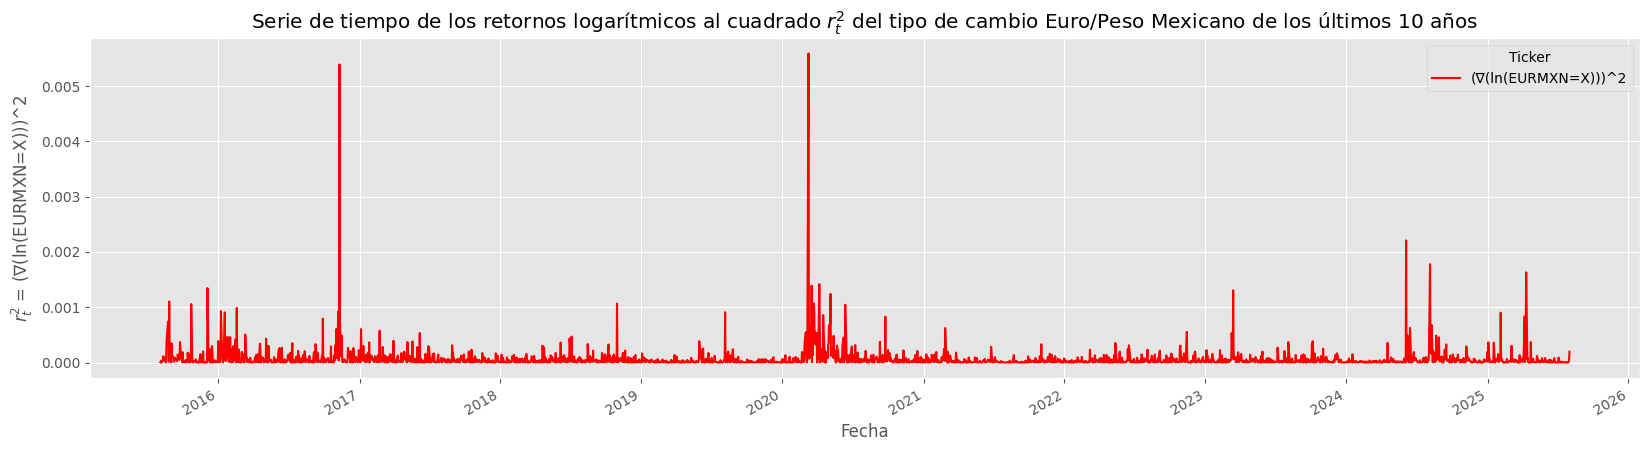

In [22]:
#Definimos la serie del cuadrado de los retornos logaritmicos
serie['(∇(ln('+Ticker+')))^2'] = (serie['∇(ln('+Ticker+'))'])**2
display(serie)

#grafico de la serie del valor absoluto de los retornos logaritmicos
serie[['(∇(ln('+Ticker+')))^2']].plot(figsize=(20,5),color='red')
plt.title(r'Serie de tiempo de los retornos logarítmicos al cuadrado $r_{t}^2$ del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.ylabel(r'$r_{t}^2$ = (∇(ln('+Ticker+')))^2')
plt.show()

#### **Autocorrelogramas simples y parciales de la serie de retornos al cuadrado $r^2_t$**

En este caso, el ACF y PACF si muestran algunas correlaciones significativas en los primeros retrasos. Esto es debido a que si bien con un retorno no podemos necesariamente saber la dirección (positiva o negativa) que tendrá el siguiente retorno, si podemos tener una idea de que tanto va a variar ese retorno siguiente.

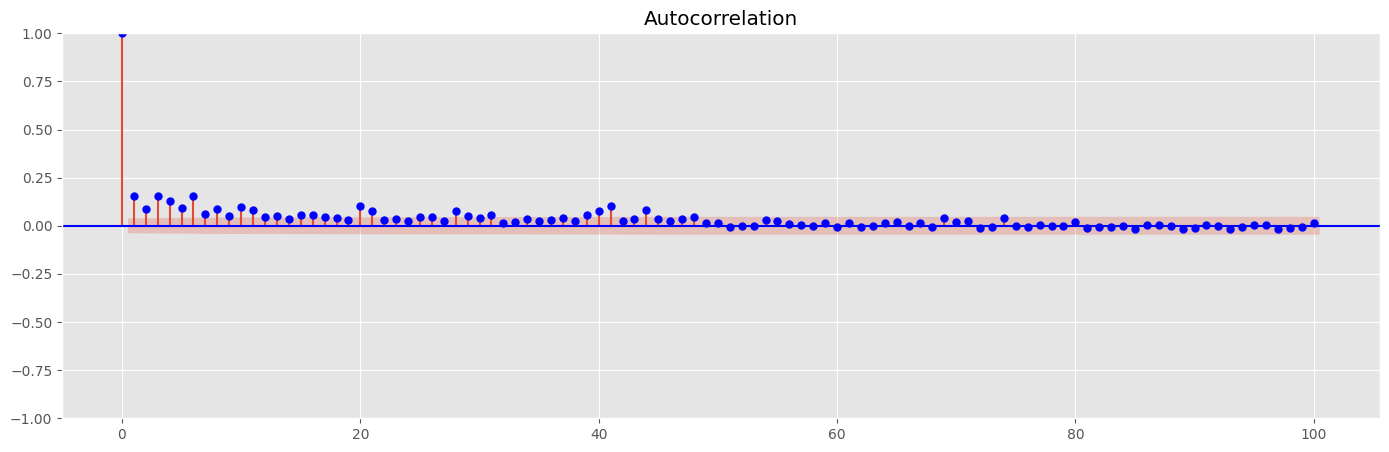

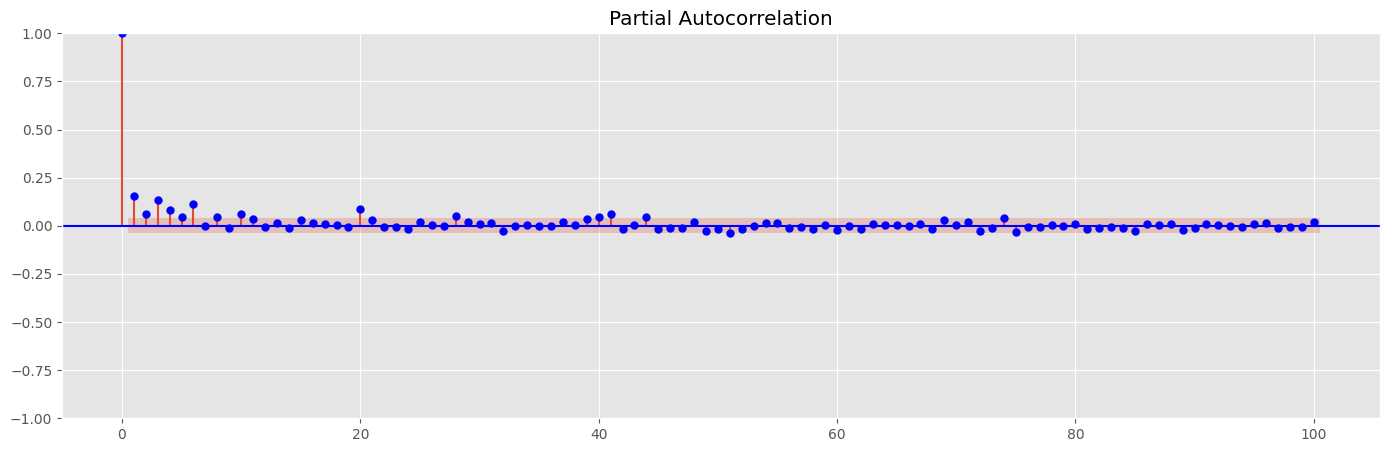

,ACF,PACF
0,1.000000,1.000000
1,0.156728,0.156788
2,0.086417,0.063461
3,0.152564,0.133909
4,0.126526,0.084698
5,0.091625,0.048286
6,0.154140,0.112323
7,0.062732,-0.003335
8,0.087655,0.045799
9,0.050099,-0.012315


In [23]:
#Autocorrelogramas simple y parcial de los retornos logaritmicos absolutos
lags = 100

#grafico de ACF
plt.style.use('ggplot')
plt.figsize=(15,10)
fig = plot_acf(serie['(∇(ln('+Ticker+')))^2'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)

#grafico de PACF
fig = plot_pacf(serie['(∇(ln('+Ticker+')))^2'].dropna(),lags=lags,c='b')
fig.set_figwidth(17)
fig.set_figheight(5)
plt.show()

#construir dataframe con las autocorrelaciones simples y parciales ACF y PACF
ACF_PACF = pd.DataFrame([acf(serie['(∇(ln('+Ticker+')))^2'].iloc[1:],nlags=lags),\
                         pacf(serie['(∇(ln('+Ticker+')))^2'].iloc[1:],nlags=lags)]).transpose()
ACF_PACF.columns = ['ACF','PACF']
display(ACF_PACF.head(10))

Al realizar la prueba de Ljung-Box para los retornos al cuadrado, con un nivel de significancia $\alpha = 0.05$, obtenemos que en este caso si se rechazan todas las hipótesis nulas para k=1,2,...,20. Por tanto, si existe autocorrelación entre los $r^2_t$ y sus valores pasados.

In [24]:
#prueba ljung-box para detectar autocorrelaciones entre los retornos logaritmicos absolutos
ljungbox_df = pd.DataFrame(columns=['lag','lb_stat', 'p_value'])

for i in range(1, 21):
    ljungbox = acorr_ljungbox(serie['(∇(ln('+Ticker+')))^2'].dropna(), lags=[i], return_df=True)
    
    lb_stat = ljungbox['lb_stat'].values[0]
    p_value = ljungbox['lb_pvalue'].values[0]

    ljungbox_df.loc[len(ljungbox_df)] = [i, lb_stat, p_value]

ljungbox_df.set_index('lag', inplace=True)
ljungbox_df

,lb_stat,p_value
lag,,
1.0,64.037429,1.220778e-15
2.0,83.513789,7.331808e-19
3.0,144.240464,4.603044e-31
4.0,186.023530,3.790408e-39
5.0,207.943365,5.670988e-43
6.0,270.002364,2.166758e-55
7.0,280.285394,9.759123e-57
8.0,300.370185,3.434599e-60
9.0,306.933710,8.821676e-61


#### **¿Qué pasa si tratamos de ajustar un modelo ARMA a la serie de retornos?**

Como la serie de retornos $r_t$ no está autocorrelacionada, entonces difícilmente vamos a poder modelar el valor de $r_t$ solamente con una combinación lineal de sus valores pasados o errores aleatorios. Al tratar de hacer un ajuste ARMA(1,1), obtenemos que la estimación de los parámetros es practicamente 0, y las pruebas de hipótesis asociadas tienen un p-value de 1, es decir, no son para nada significativos, por lo que el modelo prácticamente no está ajustando nada.

In [25]:
#Ajuste de modelo ARMA para la serie de los retornos logaritmicos
ARMA_retornos = ARIMA(serie['∇(ln('+Ticker+'))'].dropna(), order=(1,0,1), trend='n').fit()
display(ARMA_retornos.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        ∇(ln(EURMXN=X))   No. Observations:                 2604
Model:                 ARIMA(1, 0, 1)   Log Likelihood                8815.179
Date:                Fri, 01 Aug 2025   AIC                         -17624.357
Time:                        12:59:05   BIC                         -17606.763
Sample:                             0   HQIC                        -17617.983
                               - 2604                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0      0.006          0      1.000      -0.012       0.012
ma.L1              -0      0.006         -0      1.000      -0.012       0.012
sigma2      6.715e-05   8.53e-07     78.749      0.000    6.55e-05    6.88e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              6529.23
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.61e+16. Standard errors may be unstable.
"""

#### **Test LM para detectar efectos ARCH en la serie de retornos**

Si una serie de retornos tiene efectos ARCH, entonces se esperaría que pudiese expresarse de la forma:

$$r_t = \mu_t +  \epsilon_t = \mu_t + z_t \sigma_t$$

Con $\mu_t$ y $\sigma_t$ las media y volatilidades condicionales al tiempo $t-1$, y $z_t$ una variable aleatoria. La prueba LM busca contrastar la parte aleatoria de la volatilidad condicional $\epsilon_t$. Si la media fuese suficiente para modelar la serie, entonces $\epsilon_t = 0$, en caso contrario, cuando hay efecto ARCH, podría expresarse como $\epsilon^2_t = \alpha_0 + \alpha_1\epsilon^2_{t-1} + .... + \alpha_k\epsilon^2_{t-k}$. Por tanto las hipótesis son:

$$H_0 : (\alpha_0,\alpha_1,...,\alpha_k) = (0,0,...0) \qquad vs. \qquad H_a: \alpha_j \neq 0 \quad p.a. \quad j=1,2,...20$$

$$H_0 : \ No \ hay \ efecto \ ARCH \qquad vs. \qquad H_a: \ Hay \ efecto \ ARCH$$

Al aplicar la prueba LM a la serie $r_t$ para lags k=1,2,...20, con un nivel de significancia $\alpha = 0.05$, rechazamos la hipótesis nula, por tanto, tenemos efecto ARCH en la serie.

In [26]:
#Pruebas de Engle/Multiplicador de Lagrange y F para heterocedasticidad
het_arch_test_df = pd.DataFrame(columns=['lag','LM_stat', 'p_value_LM','F_stat','p_value_F'])

for i in range(1,21):
    arch_test = het_arch(serie['∇(ln('+Ticker+'))'].dropna(), nlags=i) 
    
    LM_stat = arch_test[0]
    p_value_LM = arch_test[1]
    F_stat = arch_test[2]
    p_value_F = arch_test[3]
    
    het_arch_test_df.loc[len(het_arch_test_df)] = [i, LM_stat, p_value_LM, F_stat, p_value_F]

het_arch_test_df.set_index('lag', inplace=True)
het_arch_test_df

,LM_stat,p_value_LM,F_stat,p_value_F
lag,,,,
1.0,63.950738,1.275695e-15,65.511084,8.778059e-16
2.0,74.107539,8.086345e-17,38.096062,4.931368e-17
3.0,119.274759,1.105671e-25,41.605002,2.960539e-26
4.0,136.933335,1.279619e-28,36.067031,2.256106e-29
5.0,142.581064,5.057457e-29,30.101763,7.841913e-30
6.0,173.344051,8.781447e-35,30.872726,5.394838e-36
7.0,173.373546,4.878407e-34,26.457643,3.090708e-35
8.0,178.349878,2.286040e-34,23.855351,1.259194e-35
9.0,178.664884,9.626261e-34,21.237338,5.417187e-35


#### **Ajuste de modelo GARCH**

Un modelo GARCH(p,q) se define como:

$$r_t = \mu_t +  \epsilon_t = \mu_t + z_t \sigma_t \qquad$$

Con:

* $\mu_t$ la media condicional (puede ser cero, constante, autorregresiva, etc.)
* $\sigma_t = \sqrt{\omega + \alpha_1 r^2_{t-1} + .... \alpha_p r^2_{t-p} + \beta_1 \sigma^2_{t-1} + .... \beta_q \sigma^2_{t-q}}$ la volatilidad condicional
* $z_t$ variable aleatoria de cierta distribución (Normal, t, Gaussiana, etc.)

Para obtener el modelo GARCH más adecuado para la serie de retornos, se prueban distintos modelos, variando los numeros de retrasos p,q, el tipo de media, y el tipo de distribución para $z_t$. De estos modelos, se considera el de menor BIC.

In [27]:
#Buscamos el mejor modelo GARCH para los retornos, considerando varios valores de p,q,media y distribucion diferentes
modelos = []

GARCH_mean = ['Constant', 'Zero', 'LS', 'AR']
GARCH_dist = ['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']

for p in range(1, 5):
    for q in range(0, 5):
        for mean in GARCH_mean:
            for dist in GARCH_dist:
                kwargs = {'lags': 1} if mean == 'AR' else {}

                GARCH_retornos = arch_model(serie['∇(ln(' + Ticker + '))'].dropna(), p=p, q=q, mean=mean, dist=dist, **kwargs)
                GARCH_retornos_modelo = GARCH_retornos.fit(disp='off')
                modelos.append({'p': p,'q': q,'mean': mean,'dist': dist,
                                        'AIC': np.round(GARCH_retornos_modelo.aic,2),
                                        'BIC': np.round(GARCH_retornos_modelo.bic,2)})

df_modelos = pd.DataFrame(modelos)

c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constra

En general, se observa que los modelos con menor AIC son aquellos con media constante 0 y distribución t sesgada, lo cual corresponde a lo observado tanto en la serie de tiempo como en el histograma de $r_t$. Se considera de estos, al modelo más simple, es decir, con menos parámetros, siendo este un GARCH(1,2).

In [28]:
df_modelos.sort_values('BIC', inplace=True)
df_modelos.head(20)

,p,q,mean,dist,AIC,BIC
44,1,1,Zero,skewstudent,-18326.49,-18297.17
45,1,1,Zero,skewt,-18326.49,-18297.17
397,3,2,Zero,skewt,-18332.99,-18286.07
396,3,2,Zero,skewstudent,-18332.99,-18286.07
269,2,3,Zero,skewt,-18332.75,-18285.84
268,2,3,Zero,skewstudent,-18332.75,-18285.84
140,1,4,Zero,skewstudent,-18326.39,-18279.47
141,1,4,Zero,skewt,-18326.39,-18279.47
43,1,1,Zero,studentst,-18301.83,-18278.37
42,1,1,Zero,t,-18301.83,-18278.37


Al ajustar el modelo GARCH(1,2) a la serie, obtenemos que todos los parámetros $\omega$, $\alpha_1$, $\beta_1$ y $\beta_2$ son significativos (p-values menores a 0.05), al igual que los parámetros $\eta$ y $\lambda$ de la distribución sesgada t de $z_t$.

In [29]:
GARCH_retornos = arch_model(serie['∇(ln('+Ticker+'))'].dropna(), p=1, q=2, mean='Zero', dist='skewt')
GARCH_retornos_modelo = GARCH_retornos.fit(disp='off')
GARCH_retornos_modelo

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                   ∇(ln(EURMXN=X))   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                9158.30
Distribution:      Standardized Skew Student's t   AIC:                          -18304.6
Method:                       Maximum Likelihood   BIC:                          -18269.4
                                                   No. Observations:                 2604
Date:                           Fri, Aug 01 2025   Df Residuals:                     2604
Time:                                   13:04:40   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

Respecto a los residuales estandarizados $e_t = \frac{\epsilon_t-\mu_t}{\sigma_t} = \frac{\epsilon_t}{\sigma_t}$, se observa que la distribución es ligeramente más leptocúrtica que la de una normal, además de que hay unos cuantos valores en las colas (sobretodo positivos) que no se ajustan del todo, esto se puede ver en la qq-plot, aunque estos residuos representan solo el 1% del total aproximadamente. Por tanto, podríamos asumir que los residuales siguen una distribución normal salvo en las colas, donde en casos muy extremos el modelo no está ajustando del todo correcto, lo cual se debe tomar en consideración al momento de las predicciones.

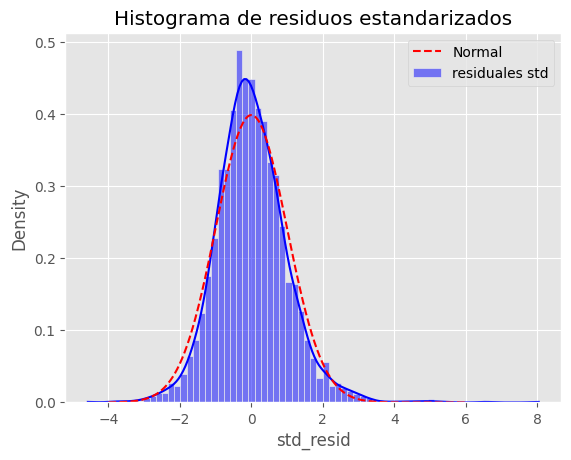

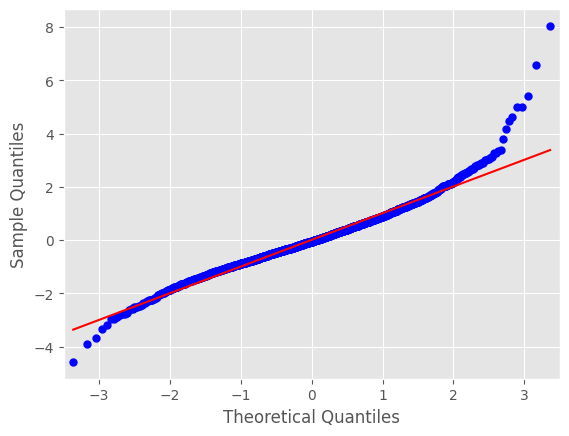

In [30]:
#Verificamos que los residuales estandarizados si tengan distribucion normal(0,1)
GARCH_retornos_modelo_residuales_std = GARCH_retornos_modelo.std_resid.dropna()

#histograma de los residuales
sns.histplot(GARCH_retornos_modelo_residuales_std, kde=True, stat="density", color='blue', label='residuales std')
plt.title("Histograma de residuos estandarizados")
#comparativo con una normal(0,1)
x = np.linspace(-4, 6, 3000)
plt.plot(x,norm.pdf(x, loc=0,scale=1),color='red',linestyle='--',label='Normal')
plt.legend()
plt.show()

#qqplot de los residuales respecto a una normal(0,1)
fig = sm.qqplot(GARCH_retornos_modelo_residuales_std, dist=scs.norm, line="s")
ax = fig.gca()
for line in ax.lines:
    line.set_markerfacecolor("blue")  
    line.set_markeredgecolor("blue")   
    line.set_markersize(5)               
plt.show()
plt.show()

Si comparamos ahora los residuales estandarizados con una t-student, notaremos que los residuales en las colas se ajustan un poco mejor, sin embargo, los casos más extremos en la cola derecha siguen sin ser capturados adecuadamente, por lo que, como se mencionó anteriormente, se debe tener en consideración al momento de predecir.

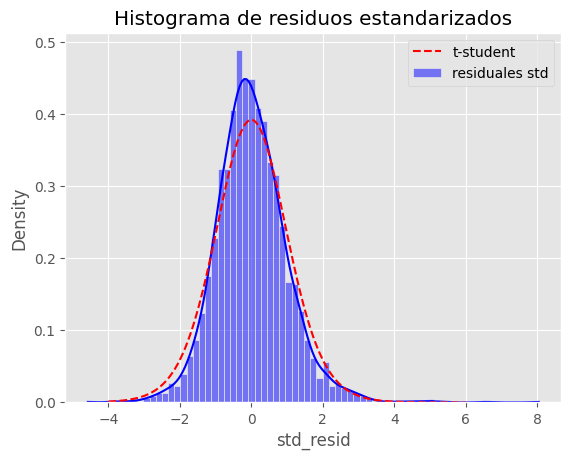

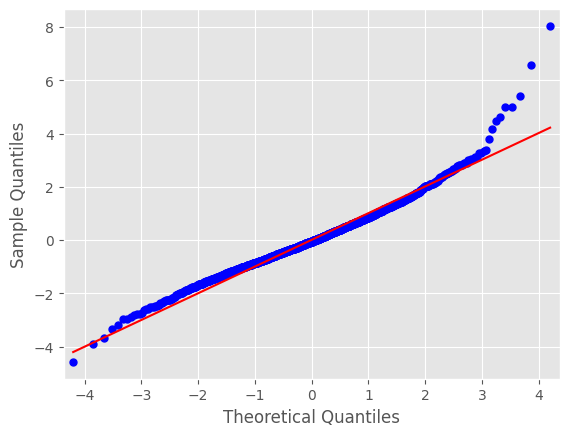

In [31]:
#histograma de los residuales
sns.histplot(GARCH_retornos_modelo_residuales_std, kde=True, stat="density", color='blue', label='residuales std')
plt.title("Histograma de residuos estandarizados")
#comparativo con una t-student
x = np.linspace(-4, 6, 3000)
plt.plot(x,t.pdf(x, df=15),color='red',linestyle='--',label='t-student')
plt.legend()
plt.show()

#qqplot de los residuales usando t-student
fig = sm.qqplot(GARCH_retornos_modelo_residuales_std, dist=scs.t, distargs=(15,), line="s")
ax = fig.gca()
for line in ax.lines:
    line.set_markerfacecolor("blue")  
    line.set_markeredgecolor("blue")   
    line.set_markersize(5)               
plt.show()

Respecto a la autocorrelación entre residuales estandarizados, las pruebas Ljung-Box para k=1,2,...,0 no se rechazan, indicando independencia entre ellos, y esto se puede verificar aún más con los autocorrelogramas simples y parciales, donde se observa que ninguna autocorrelación supera la banda de confianza. Por tanto, podemos asumir independencia de los residuales.

,lb_stat,p_value
lag,,
1.0,0.300368,0.583652
2.0,0.314857,0.854338
3.0,1.788105,0.617527
4.0,1.792320,0.773887
5.0,2.180004,0.823719
6.0,2.938533,0.816521
7.0,2.975215,0.887286
8.0,3.351560,0.910400
9.0,6.722004,0.666037


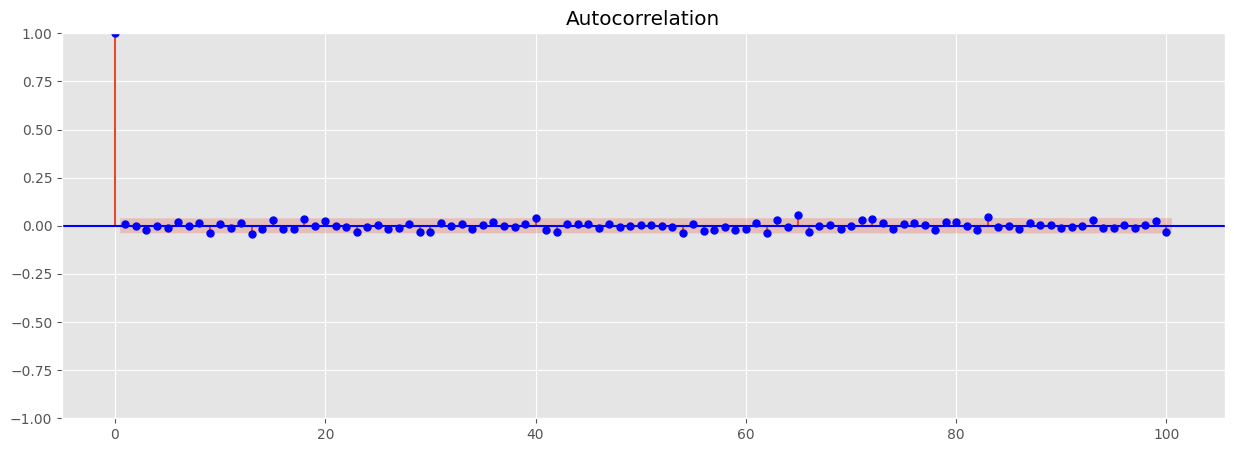

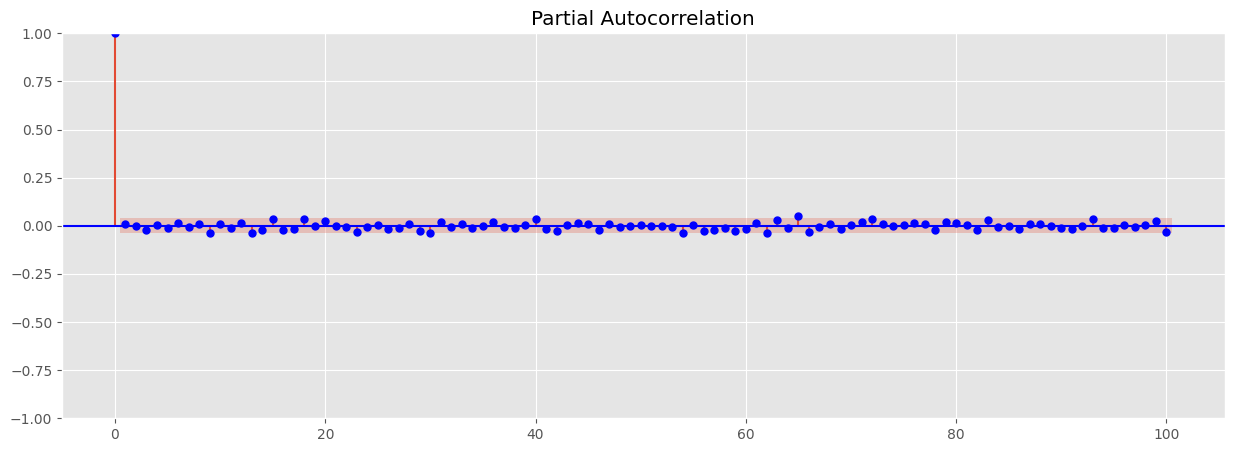

In [32]:
#Verificamos la correlacion entre residuos estandarizados
ljungbox_res_std_df = pd.DataFrame(columns=['lag','lb_stat', 'p_value'])

for i in range(1, 21):
    ljungbox = acorr_ljungbox(GARCH_retornos_modelo_residuales_std, lags=[i], return_df=True)
    
    lb_stat = ljungbox['lb_stat'].values[0]
    p_value = ljungbox['lb_pvalue'].values[0]

    ljungbox_res_std_df.loc[len(ljungbox_res_std_df)] = [i, lb_stat, p_value]

ljungbox_res_std_df.set_index('lag', inplace=True)
display(ljungbox_res_std_df)

#Autocorrelogramas simple y parcial de los residuos estandarizados
lags = 100 

#grafico de ACF
plt.style.use('ggplot')
plt.figsize=(15,5)
fig = plot_acf(GARCH_retornos_modelo_residuales_std,lags=lags,c='b')
fig.set_figwidth(15)
fig.set_figheight(5)

#grafico de PACF
fig = plot_pacf(GARCH_retornos_modelo_residuales_std,lags=lags,c='b')
fig.set_figwidth(15)
fig.set_figheight(5)
plt.show()

Finalmente, se verifica si existe algún tipo de efecto ARCH dentro de los residuales estandarizados, mediante la prueba LM y lags k=1,2,...,20. En todas las pruebas no rechazamos la hipótesis nula, es decir, no rechazamos la no presencia de efectos ARCH, es decir, no hay evidencia de heterocedasticidad condicional en los residuales estandarizados.

In [33]:
#Verificamos si los residuales tienen algun efecto ARCH
het_arch_test_res_std_df = pd.DataFrame(columns=['lag','LM_stat', 'p_value_LM','F_stat','p_value_F'])

for i in range(1,21):
    arch_test = het_arch(GARCH_retornos_modelo_residuales_std, nlags=i) 
    
    LM_stat = arch_test[0]
    p_value_LM = arch_test[1]
    F_stat = arch_test[2]
    p_value_F = arch_test[3]
    
    het_arch_test_res_std_df.loc[len(het_arch_test_res_std_df)] = [i, LM_stat, p_value_LM, F_stat, p_value_F]

het_arch_test_res_std_df.set_index('lag', inplace=True)
het_arch_test_res_std_df

,LM_stat,p_value_LM,F_stat,p_value_F
lag,,,,
1.0,1.062507,0.302644,1.062124,0.302827
2.0,1.209120,0.546315,0.604144,0.546619
3.0,1.539575,0.673167,0.512706,0.673538
4.0,1.598204,0.809115,0.399028,0.809469
5.0,1.691540,0.889964,0.337747,0.890262
6.0,1.785931,0.938296,0.297057,0.938527
7.0,1.866021,0.966882,0.265944,0.967045
8.0,1.865858,0.984852,0.232591,0.984948
9.0,2.200257,0.987890,0.243738,0.987982


#### **Análisis del ajuste de la media y volatilidad condicional $\mu_t$ y $\sigma_t$ del modelo GARCH**

Las gráficas siguientes muestran la volatilidad y varianza ajustadas con el modelo GARCH a la serie de tiempo. Se observa que en su mayoría la serie presenta una volatilidad de entre 0.005 a 0.01, teniendo algunos picos intermedios que van desde 0.01 a 0.015 e incluso 0.02, y otros picos muy elevados a finales de 2016 y durante el inicio de la pandemia en 2020, superando el valor 0.02.

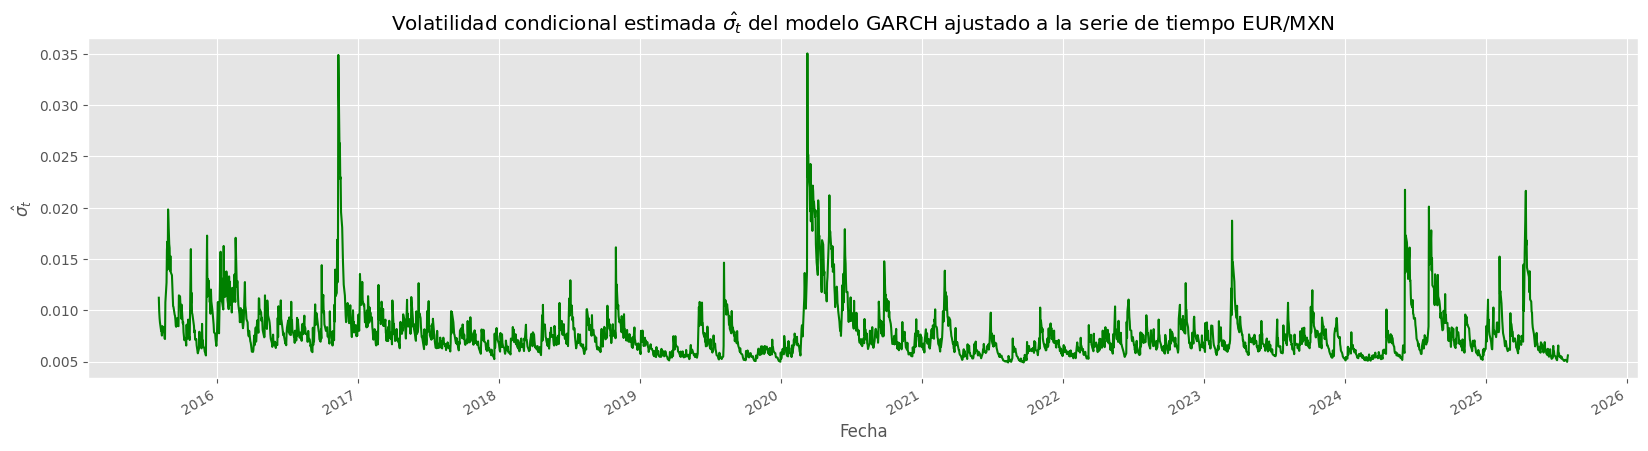

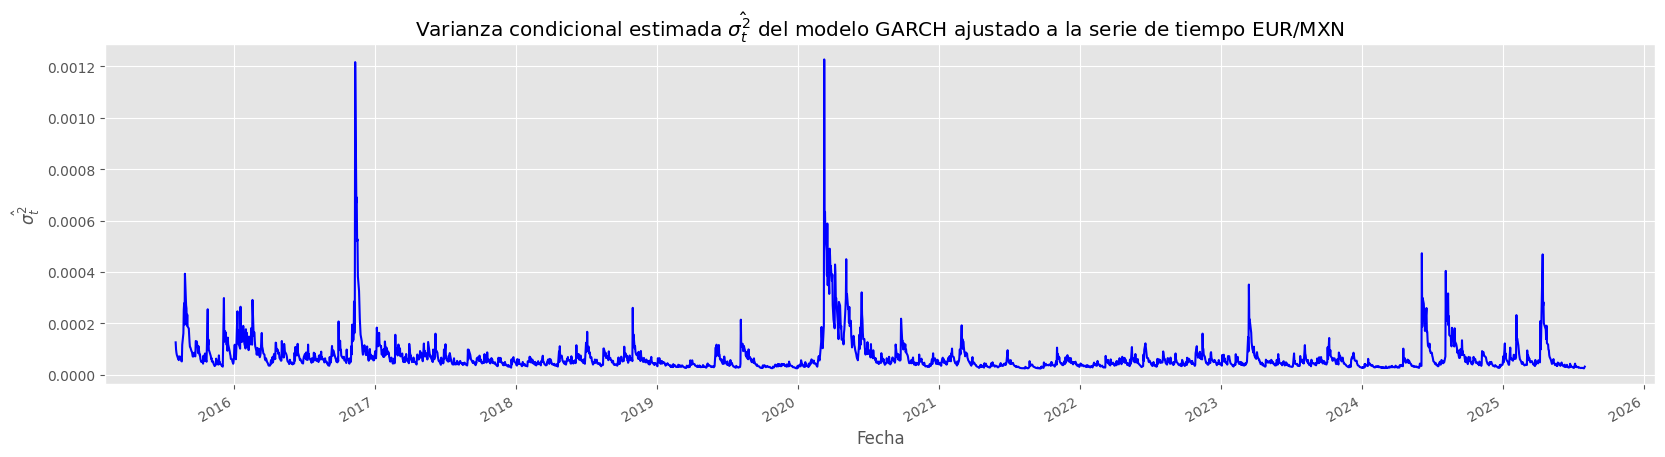

,sigma_hat,varianza_hat
Date,,
2015-08-03,NaN,NaN
2015-08-04,0.011219,0.000126
2015-08-05,0.009911,0.000098
2015-08-06,0.009239,0.000085
2015-08-07,0.008797,0.000077
...,...,...
2025-07-28,0.005069,0.000026
2025-07-29,0.005045,0.000025
2025-07-30,0.004966,0.000025


In [34]:
#Grafico de la volatilidad condicional estimada con GARCH
GARCH_retornos_modelo.conditional_volatility.plot(figsize=(20,5), color='green')
plt.title(r'Volatilidad condicional estimada $\hat{\sigma_{t}}$ del modelo GARCH ajustado a la serie de tiempo EUR/MXN')
plt.xlabel('Fecha')
plt.ylabel(r'$\hat{\sigma_{t}}$')
plt.show()

#Grafico de la varianza condicional estimada con GARCH
((GARCH_retornos_modelo.conditional_volatility)**2).plot(figsize=(20,5), color='blue')
plt.title(r'Varianza condicional estimada $\hat{\sigma^2_{t}}$ del modelo GARCH ajustado a la serie de tiempo EUR/MXN')
plt.xlabel('Fecha')
plt.ylabel(r'$\hat{\sigma^2_{t}}$')
plt.show()

#Guardamos las volatilidades condicionales en un dataframe
serie_estimaciones = pd.DataFrame(index=serie.index, columns=['sigma_hat', 'varianza_hat'])
serie_estimaciones['sigma_hat'] = GARCH_retornos_modelo.conditional_volatility
serie_estimaciones['varianza_hat'] = (GARCH_retornos_modelo.conditional_volatility)**2
display(serie_estimaciones)

Respecto a la media, dado que el modelo considera $\mu_t = 0$ para todo t, tenemos que el ajuste con GARCH toma prácticamente los mismos valores que la serie de retornos logarítmicos original.

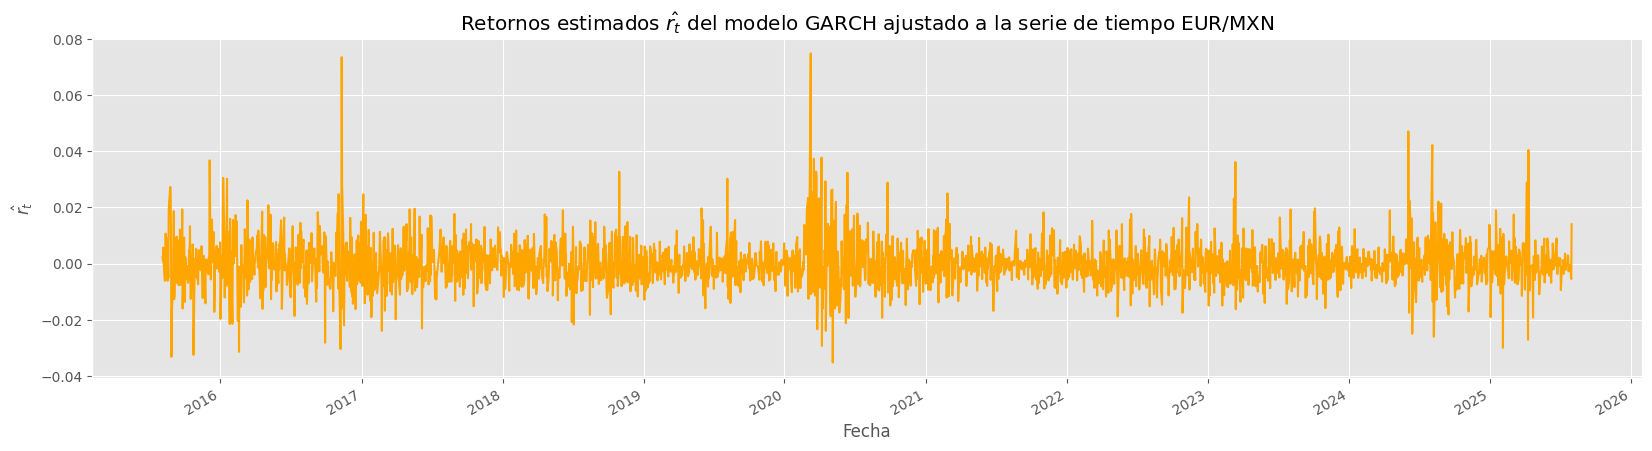

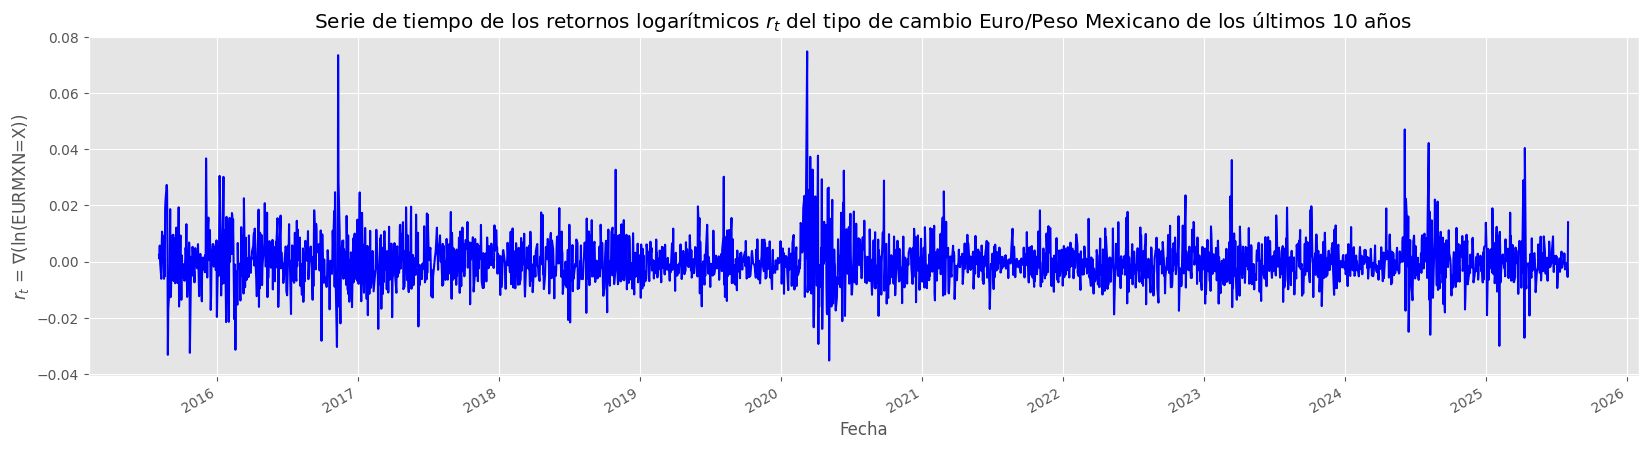

In [35]:
#Gráfico de los retornos estimados con GARCH
GARCH_retornos_modelo.resid.plot(figsize=(20,5),color='orange')
plt.title(r'Retornos estimados $\hat{r_{t}}$ del modelo GARCH ajustado a la serie de tiempo EUR/MXN')
plt.xlabel('Fecha')
plt.ylabel(r'$\hat{r_{t}}$')
plt.show()

#Grafico de la serie de los retornos logaritmicos
serie['∇(ln('+Ticker+'))'].plot(figsize=(20,5),color='blue')
plt.title(r'Serie de tiempo de los retornos logarítmicos $r_{t}$ del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.ylabel(r'$r_{t}$ = ∇(ln('+Ticker+'))')
plt.show()

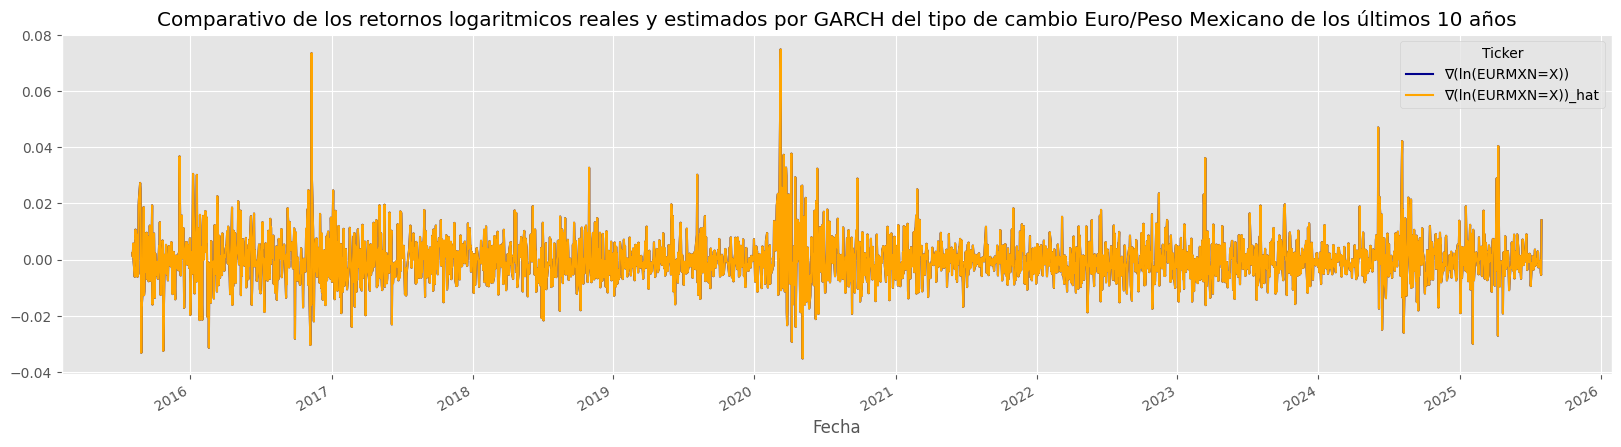

Ticker,∇(ln(EURMXN=X)),∇(ln(EURMXN=X))_hat
Date,,
2015-08-04,0.002352,0.002352
2015-08-05,0.001005,0.001005
2015-08-06,0.005664,0.005664
2015-08-07,-0.000394,-0.000394
2015-08-10,-0.006152,-0.006152
...,...,...
2025-07-28,-0.001373,-0.001373
2025-07-29,-0.000455,-0.000455
2025-07-30,-0.004594,-0.004594


In [36]:
#Combinamos ambos retornos en un mismo grafico (real y estimado)
serie['∇(ln('+Ticker+'))_hat'] = GARCH_retornos_modelo.resid

serie[['∇(ln('+Ticker+'))','∇(ln('+Ticker+'))_hat']].plot(figsize=(20,5),color=['darkblue','orange'])
plt.title('Comparativo de los retornos logaritmicos reales y estimados por GARCH del tipo de cambio Euro/Peso Mexicano de los últimos 10 años')
plt.xlabel('Fecha')
plt.show()

display(serie[['∇(ln('+Ticker+'))','∇(ln('+Ticker+'))_hat']].dropna())

#### **Value at Risk de los retornos**

El Value at Risk/Valor en Riesgo al $\alpha\%$, es ese valor tal que la probabilidad de que el retorno futuro sea menor que ese valor es $\alpha\%$. Ayuda a tener una métrica de riesgo sobre una pérdida, que si bien es poco probable, puede suceder. Con un modelo GARCH, el VaR con media y volatilidad móvil se define como:

$$VaR_{t+1|t}^{\alpha} = \mu_{t+1|t} + \sigma_{t+1|t} q_{\alpha}$$

Donde $\mu_{t+1|t}$, $\sigma_{t+1|t}$ representan la volatilidad móvil, y $q_{\alpha}$ el cuantil al $\alpha\%$ de la distribución del componente aleatorio $z_t$ en el modelo GARCH.

Esta métrica nos ayuda principalmente a evaluar que tanto nuestro modelo captura las pérdidas más extremas. Para ello, se divide a la serie de tiempo en una parte train para ajustar el modelo, y una parte test para evaluar el VaR predicho por el modelo respecto al retorno real obtenido. Dado que la serie es a 10 años, se toman los primeros 8 años (desde 2015 a 2023), para entrenar el modelo GARCH, y se toman los 2 años restantes (2023 a 2025) para evaluar.

In [37]:
#Ajuste del modelo GARCH considerando solo los primeros 8 años.
GARCH_retornos_VaR = arch_model(serie['∇(ln('+Ticker+'))'].dropna(), p=1, q=2, mean='Zero', dist='skewt')
GARCH_retornos_modelo_VaR = GARCH_retornos.fit(disp="off", last_obs=datetime.today()- timedelta(days=2*365))
GARCH_retornos_modelo_VaR

                             Zero Mean - GARCH Model Results                             
Dep. Variable:                   ∇(ln(EURMXN=X))   R-squared:                       0.000
Mean Model:                            Zero Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                7312.33
Distribution:      Standardized Skew Student's t   AIC:                          -14612.7
Method:                       Maximum Likelihood   BIC:                          -14578.8
                                                   No. Observations:                 2085
Date:                           Fri, Aug 01 2025   Df Residuals:                     2085
Time:                                   13:04:48   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

Predecimos la volatilidad y la media condicional para los siguientes 2 años.

In [38]:
#Volatilidad predicha de los últimos 2 años
GARCH_retornos_VaR_forecasts = GARCH_retornos_modelo_VaR.forecast(align="target")
mu_t = GARCH_retornos_VaR_forecasts.mean.dropna()
sigma_t = np.sqrt(GARCH_retornos_VaR_forecasts.variance.dropna())
q = GARCH_retornos_VaR.distribution.ppf([0.01,0.05], GARCH_retornos_modelo_VaR.params[-2:])

pd.DataFrame({'mu_t': mu_t.iloc[:, 0], 'sigma_t': sigma_t.iloc[:, 0]})

,mu_t,sigma_t
Date,,
2023-08-03,0.0,0.006683
2023-08-04,0.0,0.006440
2023-08-07,0.0,0.008286
2023-08-08,0.0,0.008165
2023-08-09,0.0,0.007852
...,...,...
2025-07-28,0.0,0.004409
2025-07-29,0.0,0.004355
2025-07-30,0.0,0.004288


Para evaluar la eficiencia del modelo, se cuenta la cantidad de violaciones ocurridas tanto para el VaR al $5\%$ como para el VaR al $1\%$, que corresponden a la cantidad de veces que el rendimiento real fue menor que el VaR, es decir, cuando $r_{t+1} < VaR_{t+1|t}^{\alpha}$  y se obtiene la eficiencia del modelo como: 

$$Eficiencia_{\alpha} = 1- \frac{Violaciones_{\alpha}}{Total \ observaciones}$$ 

,VaR 1%,VaR 5%,Rendimiento real,Violacion
Date,,,,
2023-08-03,-0.015325,-0.010035,0.002420,No
2023-08-04,-0.014767,-0.009669,0.019204,No
2023-08-07,-0.019001,-0.012441,-0.009891,No
2023-08-08,-0.018724,-0.012260,-0.000213,No
2023-08-09,-0.018006,-0.011790,-0.001507,No
...,...,...,...,...
2025-07-28,-0.010111,-0.006620,-0.001373,No
2025-07-29,-0.009987,-0.006539,-0.000455,No
2025-07-30,-0.009833,-0.006438,-0.004594,No


,VaR 1%,VaR 5%,Rendimiento real,Violacion
Date,,,,
2023-08-23,-0.014167,-0.009276,-0.011716,5%
2023-09-12,-0.014715,-0.009635,-0.012159,5%
2023-09-15,-0.015688,-0.010272,-0.011384,5%
2023-10-11,-0.019229,-0.012591,-0.012659,5%
2023-10-27,-0.016299,-0.010672,-0.010719,5%
2023-12-04,-0.012994,-0.008508,-0.011862,5%
2024-01-08,-0.011834,-0.007749,-0.008738,5%
2024-04-08,-0.010395,-0.006806,-0.007008,5%
2024-06-14,-0.030563,-0.020012,-0.025007,5%


,VaR 1%,VaR 5%,Rendimiento real,Violacion
Date,,,,
2023-11-02,-0.015687,-0.010272,-0.015863,1%
2024-11-07,-0.014778,-0.009676,-0.017066,1%
2025-01-03,-0.014547,-0.009525,-0.019100,1%
2025-02-04,-0.018015,-0.011796,-0.030013,1%
2025-04-10,-0.022810,-0.014935,-0.027133,1%


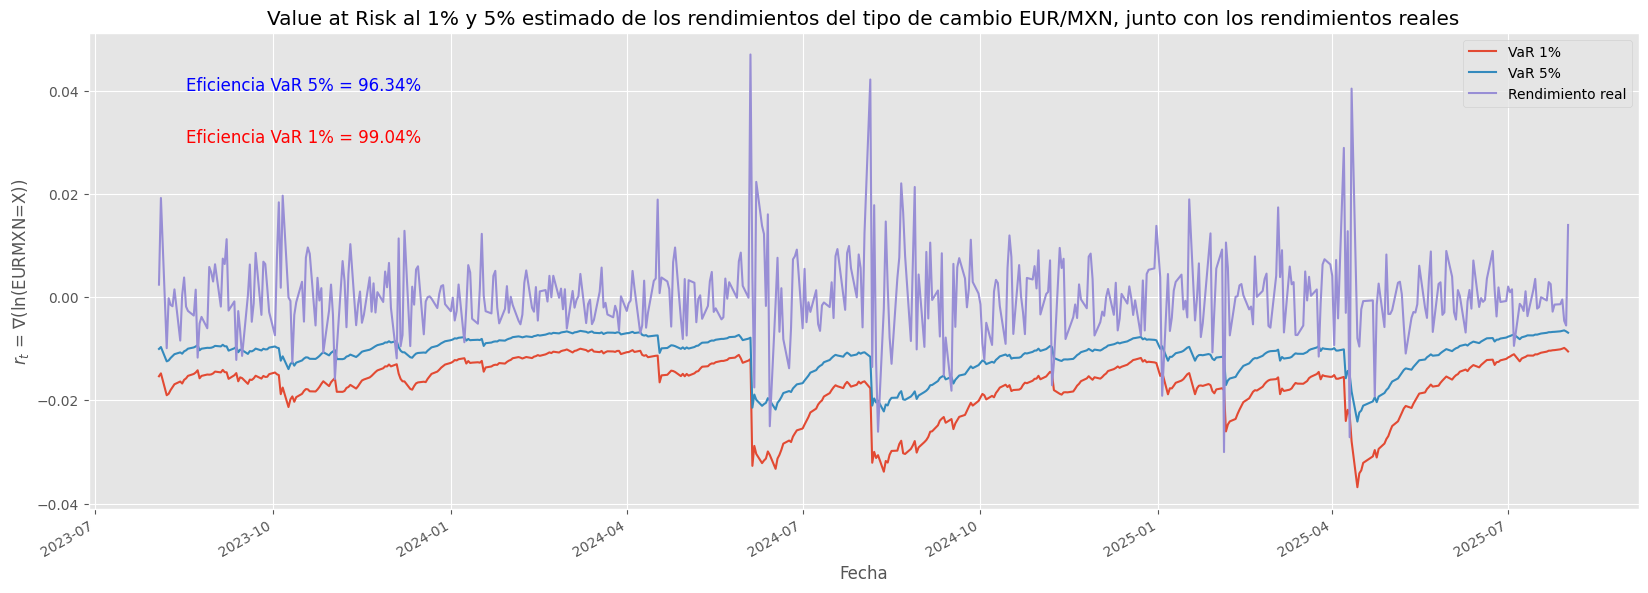

In [39]:
#Obtenemos el Value at Risk al 1% y al 5%, así como la eficiencia de cada una respecto a los rendimientos reales obtenidos
value_at_risk = mu_t.values + sigma_t.values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=['VaR 1%', 'VaR 5%'], index=sigma_t.index)
value_at_risk['Rendimiento real'] = serie[['∇(ln('+Ticker+'))']].iloc[-len(value_at_risk):]
value_at_risk['Violacion'] = 'No'
display(value_at_risk)

violaciones_VaR_5 = 0
violaciones_VaR_1 = 0
for i in value_at_risk.index:
    if value_at_risk.loc[i,'Rendimiento real'] < value_at_risk.loc[i,'VaR 5%']: 
        violaciones_VaR_5 += 1
        value_at_risk.loc[i,'Violacion'] = '5%'
    if value_at_risk.loc[i,'Rendimiento real'] < value_at_risk.loc[i,'VaR 1%']:
        violaciones_VaR_1 += 1 
        value_at_risk.loc[i,'Violacion'] = '1%'
eficiencia_VaR_5 = np.round(1-violaciones_VaR_5/len(value_at_risk),4)
eficiencia_VaR_1 = np.round(1-violaciones_VaR_1/len(value_at_risk),4)

#Mostramos en cuales fechas el rendimiento fue más bajo que el VaR
display(value_at_risk[value_at_risk['Violacion'] == '5%'])
display(value_at_risk[value_at_risk['Violacion'] == '1%']) 

#Grafico comparativo entre el VaR al 5% y 1% y los rendimientos reales
value_at_risk.plot(figsize=(20,7))
plt.title(r'Value at Risk al 1% y 5% estimado de los rendimientos del tipo de cambio EUR/MXN, junto con los rendimientos reales')
plt.text(value_at_risk.index[10], 0.03, f"Eficiencia VaR 1% = {eficiencia_VaR_1 * 100:.2f}%", color='red', fontsize=12)
plt.text(value_at_risk.index[10], 0.04, f"Eficiencia VaR 5% = {eficiencia_VaR_5 * 100:.2f}%", color='blue', fontsize=12)
plt.xlabel('Fecha')
plt.ylabel(r'$r_{t}$ = ∇(ln('+Ticker+'))')
plt.show()

En general, se observa que los modelos tienen una eficiencia bastante alta, aproximadamente de $1-\alpha$ en ambos casos. En general, el modelo falla cuando la volatilidad se mantiene baja y crece de manera espontánea en un día, sin embargo con el modelo GARCH, se ajusta rápidamente este cambio. En particular, a pesar de que el VaR al $1\%$ es más eficiente, notemos que en muchos casos sobreestima la pérdida debido a que en días anteriores hubo volatilidad alta, lo cual tampoco es termina siendo útil pues se perderían oportunidades de inversión. De esta manera, la significancia $\alpha$ depende de la aversión al riesgo que tenga cada inversionista, pero en general, podemos decir que el modelo GARCH si está prediciendo de manera adecuada.

#### **Pronóstico de la volatilidad condicional, los retornos logarítmicos, y el precio a 5 días**

Una vez evaluada la eficacia del modelo, se procede a realizar el pronóstico para la siguiente semana. Para ello se obtienen primero las volatilidades condicionales $\sigma_t$ predichas de los siguientes 5 días. Dado que el modelo es de media 0, entonces las medias volatiles que predecirá el modelo son 0, por lo que se omite obtenerlas.

In [40]:
h = 5 #Numero de periodos a predecir
fechas_forecast = pd.date_range(start=serie_estimaciones.index[-1] + pd.Timedelta(days=1), periods=h, freq='B')
df_fechas_forecast = pd.DataFrame(index=fechas_forecast, columns=serie_estimaciones.columns)
serie_estimaciones = pd.concat([serie_estimaciones, df_fechas_forecast])

#Obtenemos las predicciones de volatilidad y varianza
GARCH_retornos_forecast = GARCH_retornos_modelo.forecast(horizon=h)
serie_estimaciones.loc[serie_estimaciones.index[-h:],'sigma_prediccion'] = np.sqrt(GARCH_retornos_forecast.variance.values[-1, :])
serie_estimaciones.loc[serie_estimaciones.index[-h:],'varianza_prediccion'] = GARCH_retornos_forecast.variance.values[-1, :]

#la prediccion de la ultima observacion es su estimacion
serie_estimaciones.loc[serie_estimaciones.index[-h-1],'sigma_prediccion'] = serie_estimaciones.loc[serie_estimaciones.index[-h-1],'sigma_hat']
serie_estimaciones.loc[serie_estimaciones.index[-h-1],'varianza_prediccion'] = serie_estimaciones.loc[serie_estimaciones.index[-h-1],'varianza_hat']

serie_estimaciones.tail(h+10)

,sigma_hat,varianza_hat,sigma_prediccion,varianza_prediccion
2025-07-21,0.005115,0.000026,NaN,NaN
2025-07-22,0.005062,0.000026,NaN,NaN
2025-07-23,0.005152,0.000027,NaN,NaN
2025-07-24,0.005124,0.000026,NaN,NaN
2025-07-25,0.005174,0.000027,NaN,NaN
2025-07-28,0.005069,0.000026,NaN,NaN
2025-07-29,0.005045,0.000025,NaN,NaN
2025-07-30,0.004966,0.000025,NaN,NaN
2025-07-31,0.005337,0.000028,NaN,NaN
2025-08-01,0.005600,0.000031,0.005600,0.000031


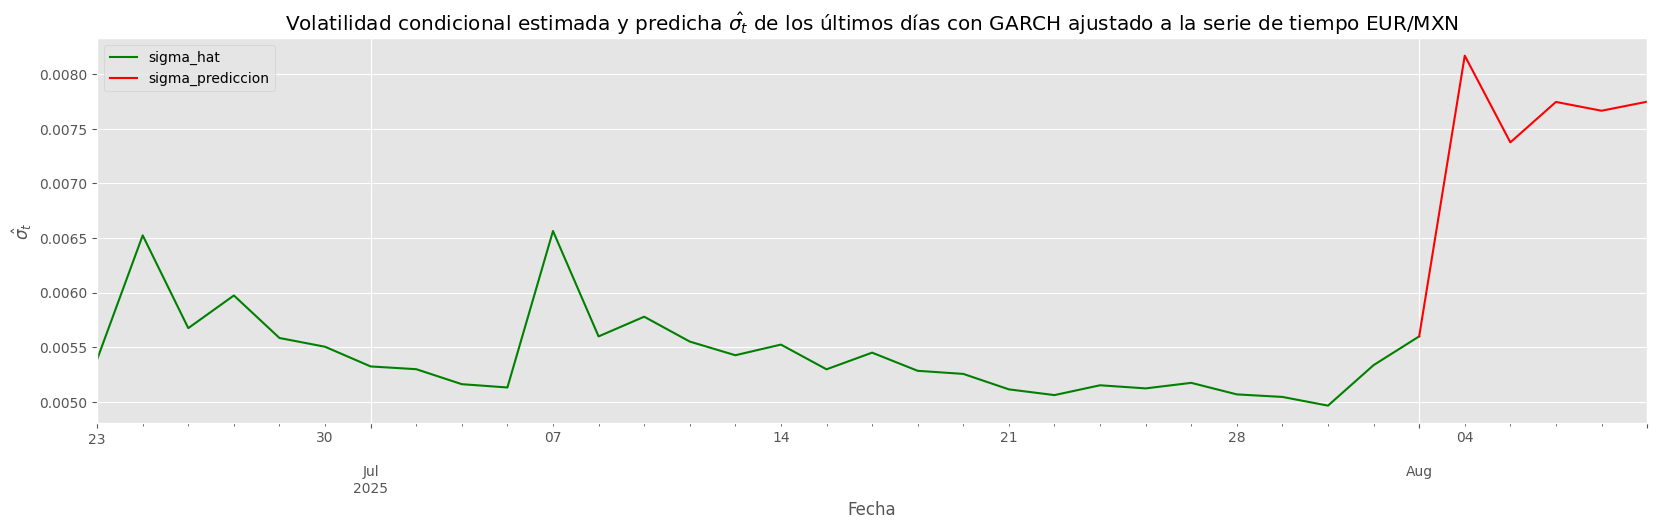

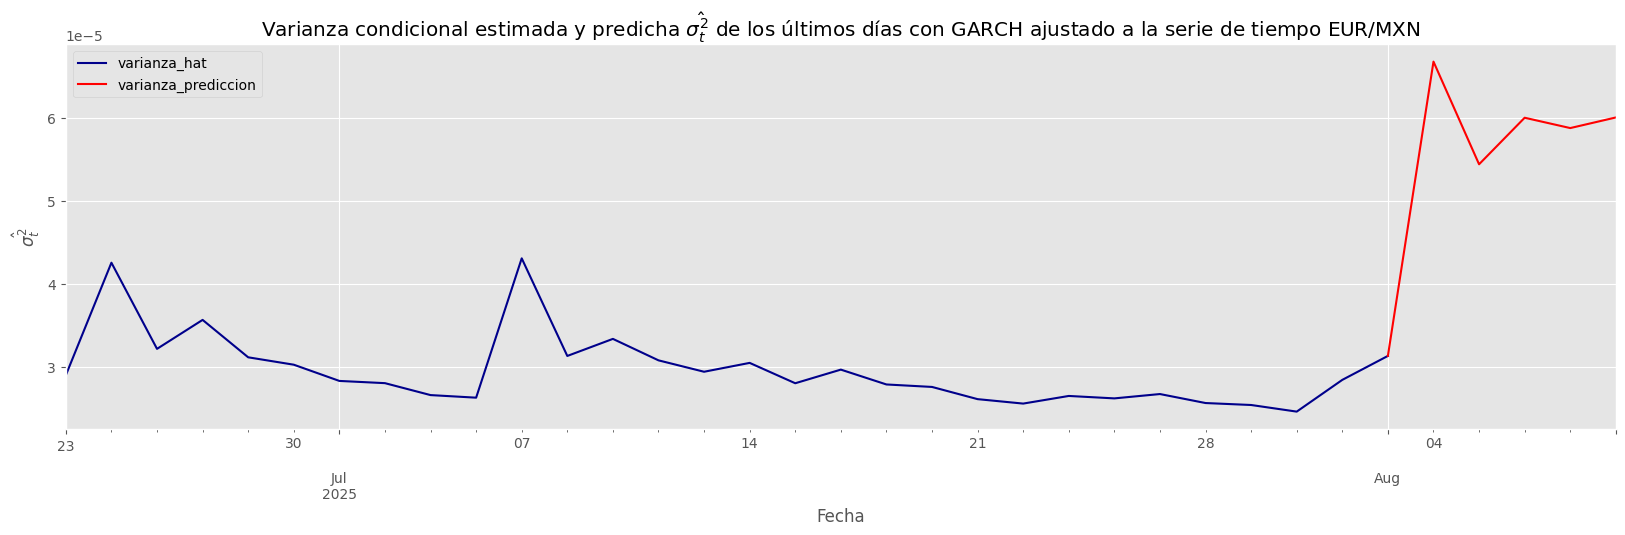

In [41]:
#Graficamos las volatilidad condicional estimada y predicha
serie_estimaciones[['sigma_hat','sigma_prediccion']].iloc[-30-h:].plot(figsize=(20,5), color=['green','red'])
plt.title(r'Volatilidad condicional estimada y predicha $\hat{\sigma_{t}}$ de los últimos días con GARCH ajustado a la serie de tiempo EUR/MXN')
plt.xlabel('Fecha')
plt.ylabel(r'$\hat{\sigma_{t}}$')
plt.show()

#Graficamos las varianza condicional estimada y predicha
serie_estimaciones[['varianza_hat','varianza_prediccion']].iloc[-30-h:].plot(figsize=(20,5), color=['darkblue','red'])
plt.title(r'Varianza condicional estimada y predicha $\hat{\sigma^2_{t}}$ de los últimos días con GARCH ajustado a la serie de tiempo EUR/MXN')
plt.xlabel('Fecha')
plt.ylabel(r'$\hat{\sigma^2_{t}}$')
plt.show()

Para predecir los retornos y precios futuros, se simulan varias caminatas aleatorias que podrían tomar ambos. Para cada escenario, se simulan 5 valores aleatorios de $z_t$ correspondientes a la distribución especificada en el modelo GARCH, y se obtienen los retornos como:

$$\hat{r}_{t+k} = z_{t+k}\hat{\sigma}_{t+k}, \qquad k=1,2,3,4,5$$

Una vez obtenidos los retornos, se simula el precio. Dado que los retornos se obtienen como $r_{t+k} = ln(P_{t+k})-ln(P_{t+k-1})$, al despejar $P_{t+k-1}$, tenemos que el precio de mañana se puede encontrar como:

$$\hat{P}_{t+1} = P_{t}e^{\hat{r}_{t+1}} $$

Donde $P_{t}$ es el último precio disponible. Y para los siguientes 4 días, hacemos:

$$\hat{P}_{t+k} = \hat{P}_{t+k-1}e^{\hat{r}_{t+k}}, \quad k=2,3,4,5$$

,∇(ln(EURMXN=X)),Escenario1,Escenario2,Escenario3,Escenario4,Escenario5,Escenario6,Escenario7,Escenario8,Escenario9,...,Escenario991,Escenario992,Escenario993,Escenario994,Escenario995,Escenario996,Escenario997,Escenario998,Escenario999,Escenario1000
2025-08-01,0.01398,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,...,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980,0.013980
2025-08-04,NaN,-0.006659,0.000254,-0.000809,-0.006838,-0.005421,-0.000614,0.005999,-0.013896,0.008993,...,0.009222,-0.010348,-0.003367,0.000781,0.008162,0.012419,0.003791,0.002172,0.002457,0.003623
2025-08-05,NaN,0.000516,-0.004342,-0.018600,-0.005243,-0.007156,0.005591,0.004382,-0.010672,0.000271,...,-0.006669,-0.019814,0.001436,-0.003848,0.004294,0.004544,-0.001929,-0.002459,0.001453,0.003673
2025-08-06,NaN,-0.001856,-0.006400,0.001049,0.011029,0.006200,0.008683,-0.004122,0.007521,0.005368,...,-0.004679,-0.002565,0.007273,0.003122,-0.003861,0.021522,0.006989,-0.006343,-0.004089,-0.000952
2025-08-07,NaN,0.007289,0.009003,-0.000275,0.003018,0.003972,0.000344,-0.007500,0.004294,0.001880,...,0.002178,0.009425,-0.007448,-0.005689,0.001895,0.006083,-0.008048,-0.000595,-0.005959,-0.011137
2025-08-08,NaN,0.005799,0.007658,-0.000818,-0.003228,0.014586,0.007081,0.003628,-0.002178,-0.003100,...,0.003240,0.001751,0.029721,0.013574,0.002373,-0.006086,0.008492,-0.011581,0.018782,-0.001712


,EURMXN=X,Escenario1,Escenario2,Escenario3,Escenario4,Escenario5,Escenario6,Escenario7,Escenario8,Escenario9,...,Escenario991,Escenario992,Escenario993,Escenario994,Escenario995,Escenario996,Escenario997,Escenario998,Escenario999,Escenario1000
2025-08-01,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,...,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861,21.836861
2025-08-04,NaN,21.691940,21.842403,21.819208,21.688055,21.718795,21.823467,21.968243,21.535508,22.034134,...,22.039173,21.612066,21.763457,21.853931,22.015820,22.109753,21.919802,21.884334,21.890583,21.916115
2025-08-05,NaN,21.703136,21.747769,21.417121,21.574642,21.563923,21.945821,22.064719,21.306894,22.040114,...,21.892679,21.188066,21.794734,21.769991,22.110553,22.210449,21.877568,21.830595,21.922418,21.996762
2025-08-06,NaN,21.662895,21.609037,21.439607,21.813896,21.698040,22.137204,21.973950,21.467749,22.158743,...,21.790488,21.133784,21.953824,21.838067,22.025341,22.693636,22.031007,21.692555,21.832957,21.975839
2025-08-07,NaN,21.821375,21.804470,21.433710,21.879820,21.784394,22.144831,21.809769,21.560133,22.200445,...,21.837991,21.333919,21.790923,21.714184,22.067112,22.832106,21.854407,21.679656,21.703234,21.732457
2025-08-08,NaN,21.948278,21.972083,21.416191,21.809310,22.104472,22.302197,21.889037,21.513226,22.131725,...,21.908870,21.371298,22.448287,22.010933,22.119536,22.693576,22.040790,21.430042,22.114706,21.695289


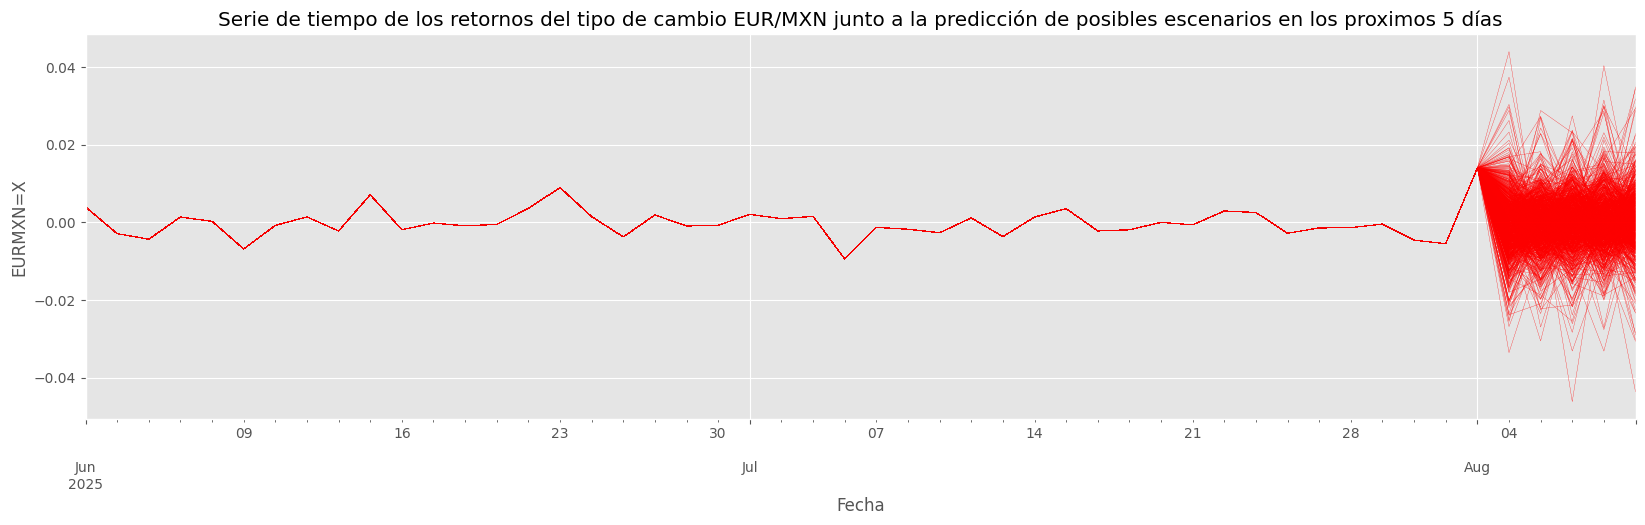

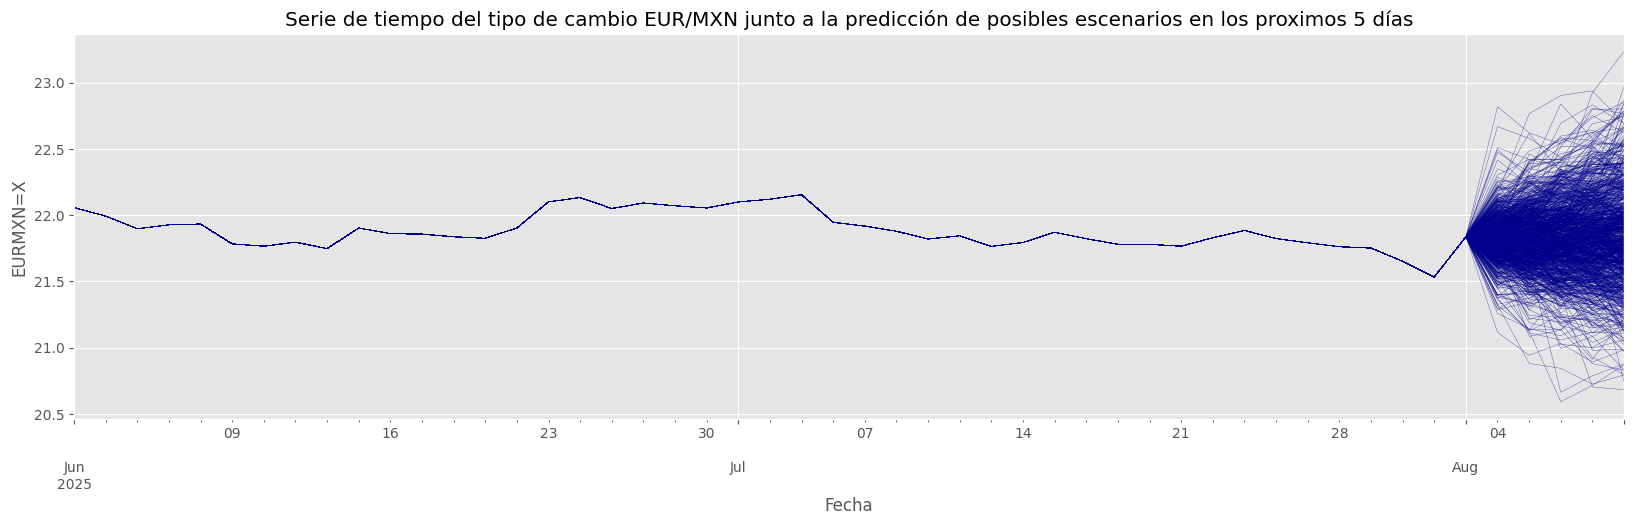

In [42]:
#Simulamos caminatas/escenarios posibles del precio durante 5 dias
h=5
escenarios = 1000
fechas_forecast = pd.date_range(start=serie.index[-1] + pd.Timedelta(days=1), periods=h, freq='B')
df_fechas_forecast_retornos = pd.DataFrame(index=fechas_forecast, columns=['∇(ln('+Ticker+'))'])
df_fechas_forecast_serie = pd.DataFrame(index=fechas_forecast, columns=[Ticker])
retornos_escenarios = pd.concat([serie[['∇(ln('+Ticker+'))']], df_fechas_forecast_retornos])
serie_escenarios = pd.concat([serie[[Ticker]], df_fechas_forecast_serie])

#volatilidad condicional estimada a h periodos
GARCH_retornos_forecast = GARCH_retornos_modelo.forecast(horizon=h)
sigma_t = np.sqrt(GARCH_retornos_forecast.variance.values[-1, :])

#estimamos los escenarios para las volatilidades y precios futuros
for i in range(0,escenarios):
  u = uniform(size=5)
  z = GARCH_retornos.distribution.ppf(u, GARCH_retornos_modelo.params[-2:])
  retornos_t = z*sigma_t
  retornos_escenarios['Escenario'+str(i+1)] = list(serie['∇(ln('+Ticker+'))'])+list(retornos_t)

  precios = np.zeros(h)
  precios[0] = serie[Ticker].iloc[-1]*np.exp(retornos_t[0])
  for j in range(1,h):
    precios[j] = precios[j-1]*np.exp(retornos_t[j])

  serie_escenarios['Escenario'+str(i+1)] = list(serie[Ticker])+list(precios)

display(retornos_escenarios.tail(h+1))
display(serie_escenarios.tail(h+1))

#Grafico de la serie de las ultimas 100 observaciones mas los escenarios futuros
retornos_escenarios.tail(50).plot(figsize=(20,5),legend=False,color='red',linewidth = 0.2)
plt.title('Serie de tiempo de los retornos del tipo de cambio EUR/MXN junto a la predicción de posibles escenarios en los proximos 5 días')
plt.xlabel('Fecha')
plt.ylabel(Ticker)
plt.show()

#Grafico de la serie de las ultimas 100 observaciones mas los escenarios futuros
serie_escenarios.tail(50).plot(figsize=(20,5),legend=False,color='darkblue',linewidth = 0.2)
plt.title('Serie de tiempo del tipo de cambio EUR/MXN junto a la predicción de posibles escenarios en los proximos 5 días')
plt.xlabel('Fecha')
plt.ylabel(Ticker)
plt.show()

Las siguientes tablas muestran estadísticas de los rendimientos y el precio por día, obteniendo el mínimo, la media, y el máximo, así como los cuantiles al 1%,5%,25%,75%,95% y 99%.

In [43]:
#Estadisticas de la muestra de rendimientos generados, como min,max,media,asi como los cuantiles al 5%,25%,75%,95% para tener un intervalo.
retornos_predicciones = pd.DataFrame(index=serie_estimaciones.tail(5).index, 
                                     columns=['min_retorno','1%_retorno','5%_retorno',
                                              '25%_retorno','media_retorno','75%_retorno',
                                              '95%_retorno','99%_retorno','max_retorno'])
precios_predicciones = pd.DataFrame(index=serie_estimaciones.tail(5).index, 
                                     columns=['min_precio','1%_precio','5%_precio',
                                              '25%_precio','media_precio','75%_precio',
                                              '95%_precio','99%_precio','max_precio'])
h=5
for i in range(0,h):
    retornos_predicciones.loc[retornos_predicciones.index[i],'min_retorno'] = np.min(retornos_escenarios.iloc[-h+i].dropna())
    retornos_predicciones.loc[retornos_predicciones.index[i],'1%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),1)
    retornos_predicciones.loc[retornos_predicciones.index[i],'5%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),5)
    retornos_predicciones.loc[retornos_predicciones.index[i],'25%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),25)
    retornos_predicciones.loc[retornos_predicciones.index[i],'media_retorno'] = np.mean(retornos_escenarios.iloc[-h+i].dropna())
    retornos_predicciones.loc[retornos_predicciones.index[i],'75%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),75)
    retornos_predicciones.loc[retornos_predicciones.index[i],'95%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),95)
    retornos_predicciones.loc[retornos_predicciones.index[i],'99%_retorno'] = np.percentile(retornos_escenarios.iloc[-h+i].dropna(),99)
    retornos_predicciones.loc[retornos_predicciones.index[i],'max_retorno'] = np.max(retornos_escenarios.iloc[-h+i].dropna())

    precios_predicciones.loc[precios_predicciones.index[i],'min_precio'] = np.min(serie_escenarios.iloc[-h+i].dropna())
    precios_predicciones.loc[precios_predicciones.index[i],'1%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),1)
    precios_predicciones.loc[precios_predicciones.index[i],'5%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),5)
    precios_predicciones.loc[precios_predicciones.index[i],'25%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),25)
    precios_predicciones.loc[precios_predicciones.index[i],'media_precio'] = np.mean(serie_escenarios.iloc[-h+i].dropna())
    precios_predicciones.loc[precios_predicciones.index[i],'75%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),75)
    precios_predicciones.loc[precios_predicciones.index[i],'95%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),95)
    precios_predicciones.loc[precios_predicciones.index[i],'99%_precio'] = np.percentile(serie_escenarios.iloc[-h+i].dropna(),99)
    precios_predicciones.loc[precios_predicciones.index[i],'max_precio'] = np.max(serie_escenarios.iloc[-h+i].dropna())

display(retornos_predicciones)
display(precios_predicciones)

,min_retorno,1%_retorno,5%_retorno,25%_retorno,media_retorno,75%_retorno,95%_retorno,99%_retorno,max_retorno
2025-08-04,-0.033545,-0.021151,-0.013062,-0.004962,-0.000356,0.004198,0.012251,0.019162,0.043944
2025-08-05,-0.030537,-0.018727,-0.012012,-0.004279,-0.000264,0.004073,0.0104,0.017569,0.028784
2025-08-06,-0.046159,-0.020804,-0.011964,-0.004251,0.00002,0.004433,0.011618,0.020926,0.027409
2025-08-07,-0.033154,-0.01824,-0.01127,-0.003812,0.000388,0.004288,0.012564,0.019376,0.040326
2025-08-08,-0.043626,-0.020161,-0.011804,-0.003894,0.00035,0.004686,0.013149,0.019601,0.034859


,min_precio,1%_precio,5%_precio,25%_precio,media_precio,75%_precio,95%_precio,99%_precio,max_precio
2025-08-04,21.116493,21.379833,21.553485,21.728785,21.82977,21.92873,22.106038,22.259323,22.817846
2025-08-05,20.881948,21.211496,21.459565,21.681082,21.824548,21.970345,22.210555,22.400121,22.765314
2025-08-06,20.593368,21.137501,21.386368,21.650577,21.825595,21.999976,22.300031,22.515808,22.903305
2025-08-07,20.704041,21.000942,21.335114,21.628623,21.834653,22.034666,22.383088,22.626165,22.937755
2025-08-08,20.683534,20.983121,21.252642,21.598931,21.842987,22.056462,22.481036,22.773402,23.233976


Finalmente, basándonos en estos escenarios simulados, si queremos obtener la probabilidad de que en los siguientes 5 días, el tipo de cambio EUR/MXN supere cierto precio, basta contar cuantas de estas caminatas superaron dicho precio en alguno de los 5 días, y para obtener la probabilidad, dividimos ese conteo entre el número de escenarios totales simulados.

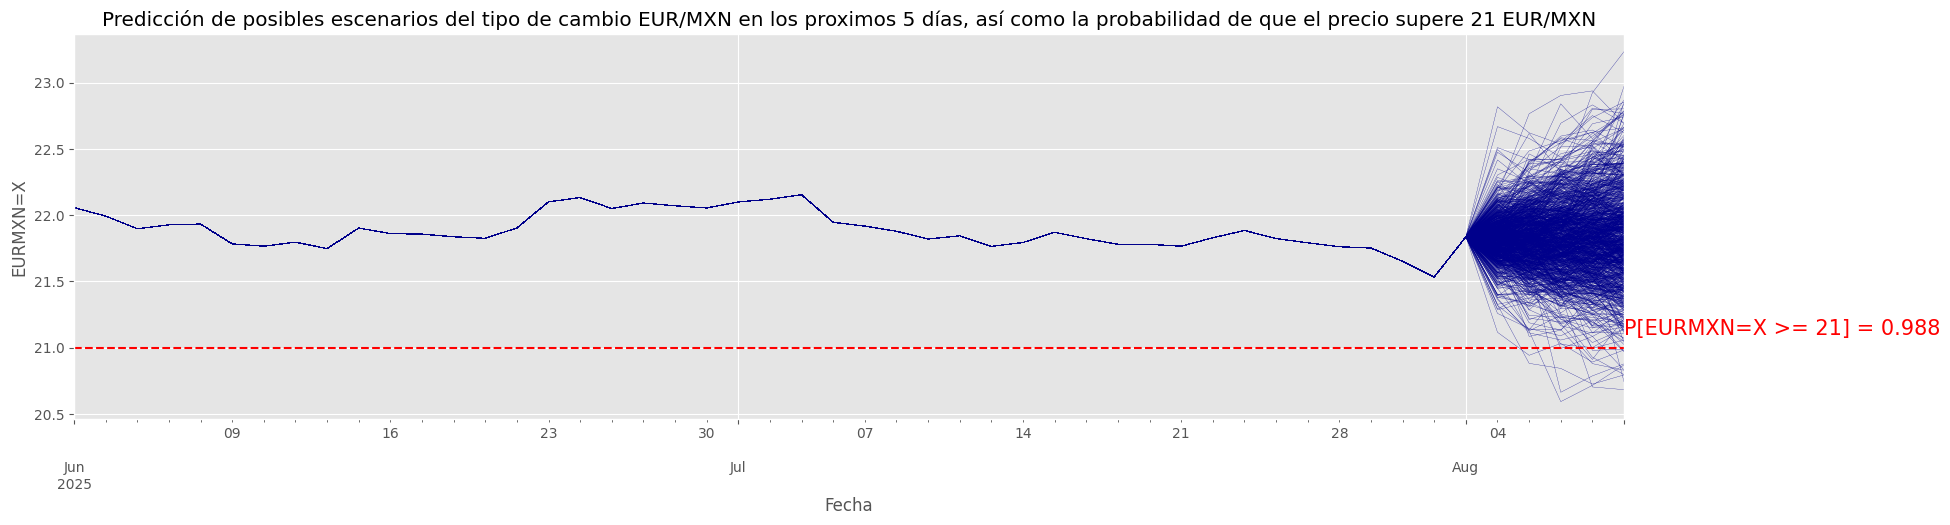

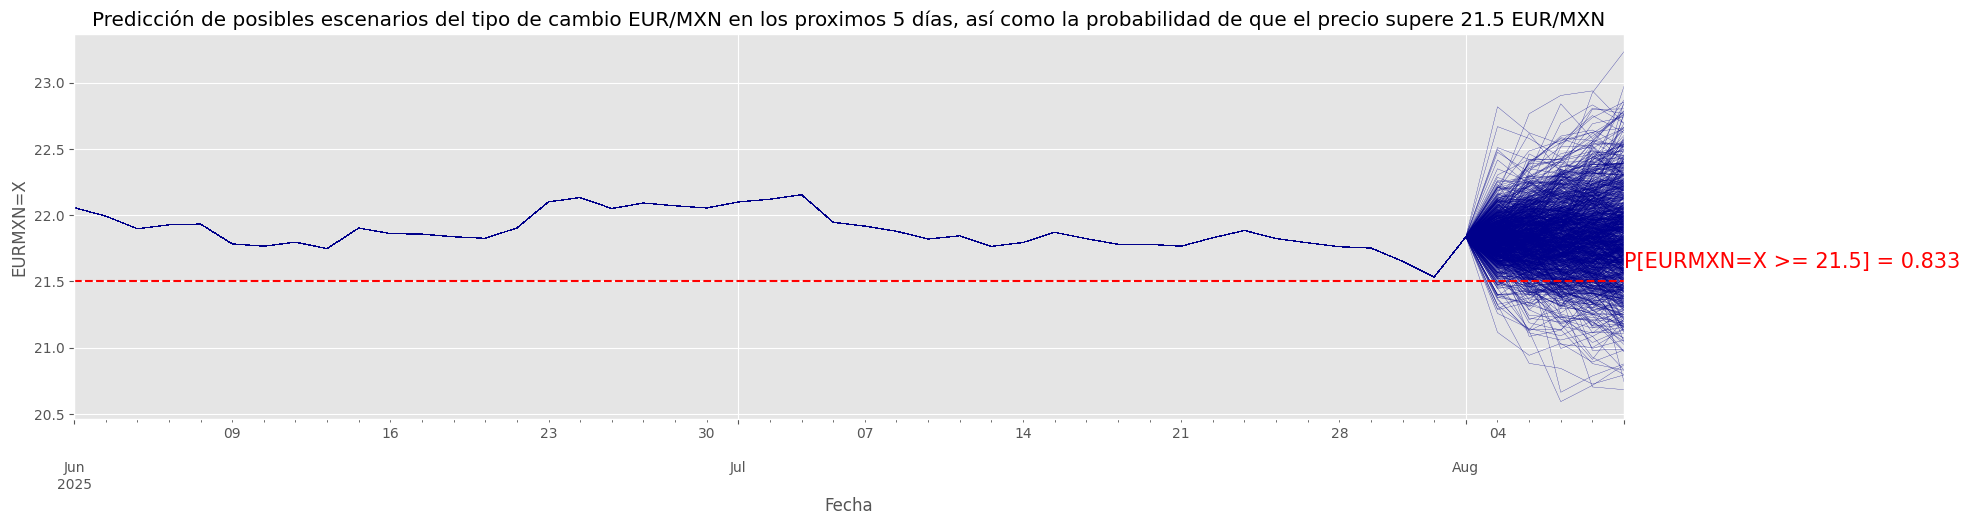

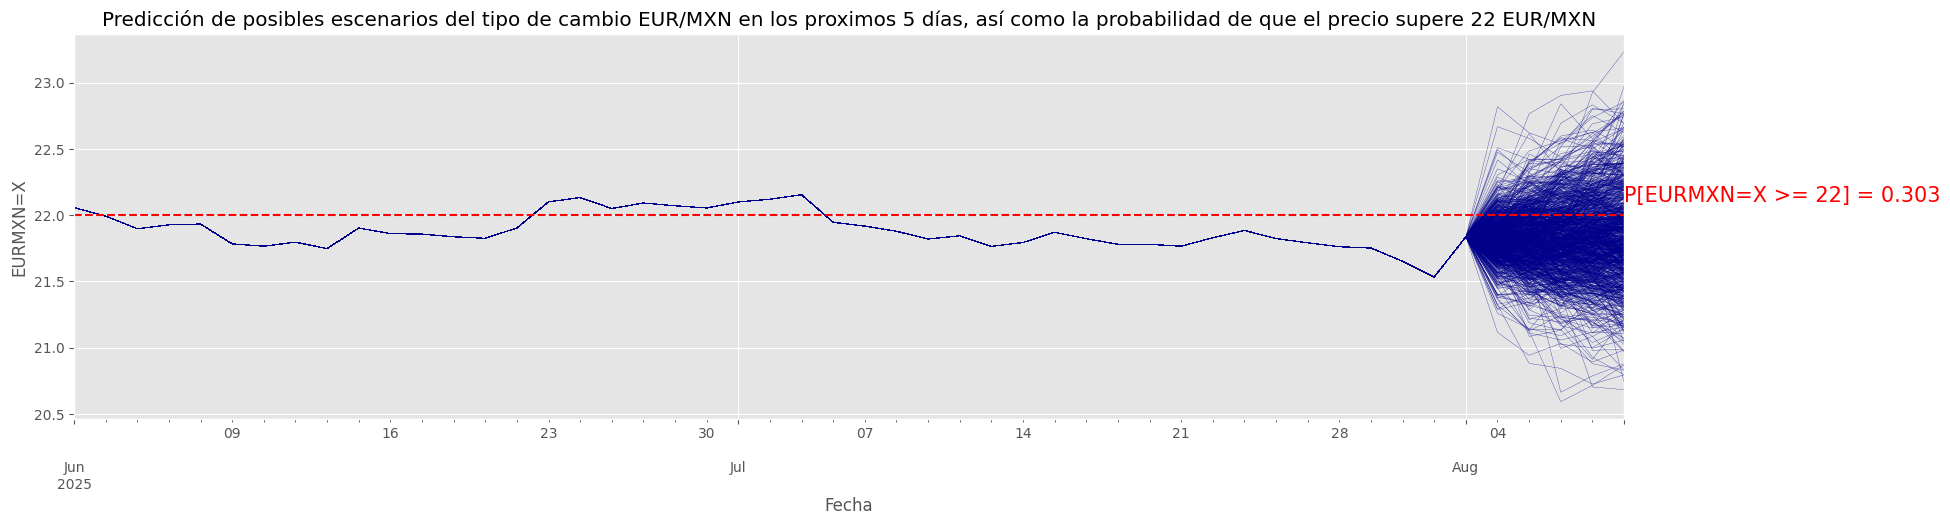

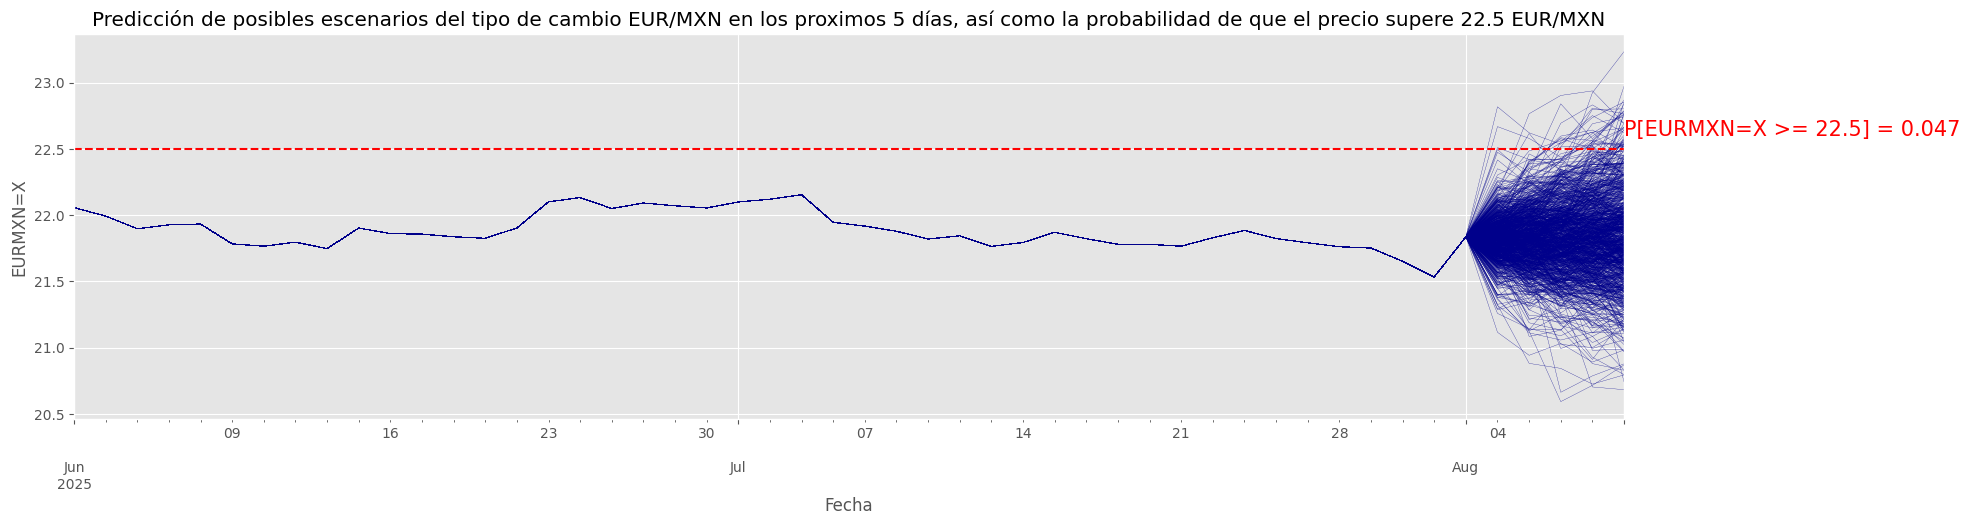

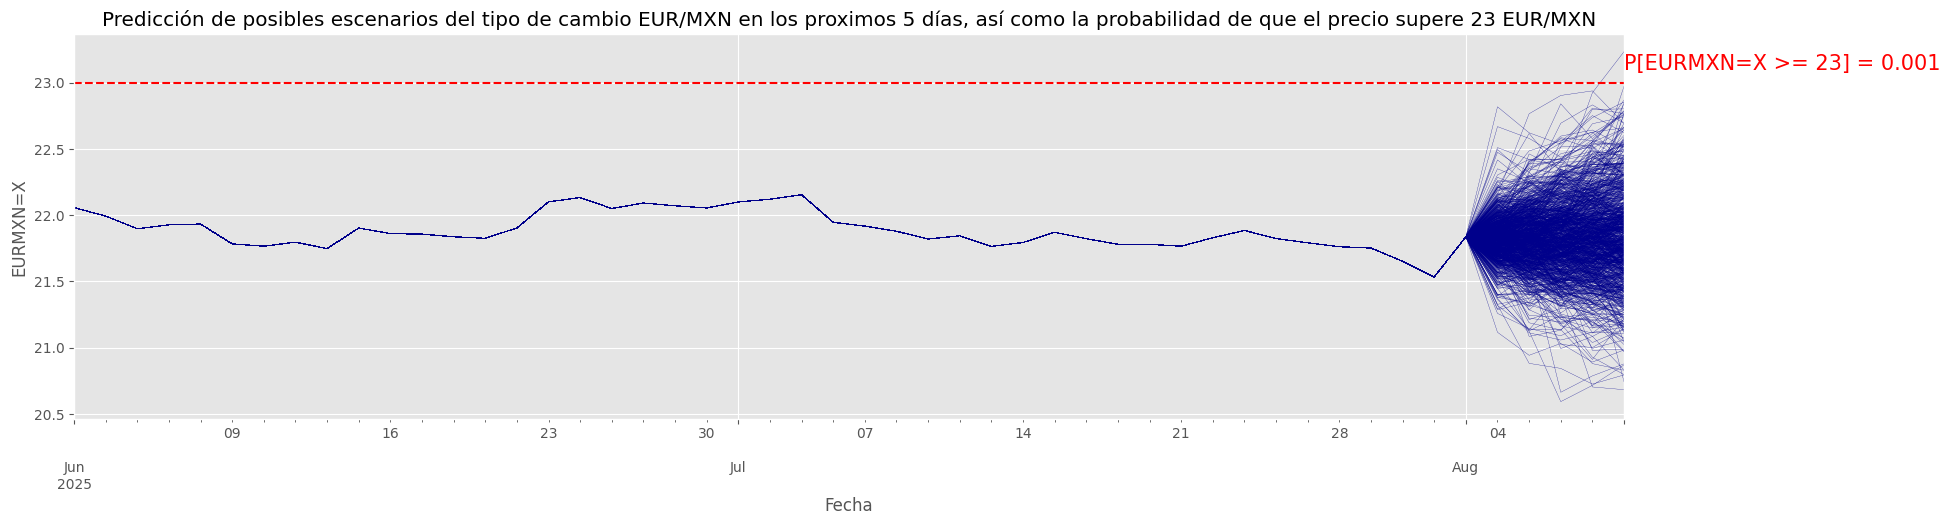

In [44]:
#Función para calcular la probabilidad de que la predicción a 5 días alcance cierto precio en alguno de los 5 días
def probabilidad_alcanzar_precio(precio):
  contador = np.zeros(escenarios)
  for i in range(0,escenarios):
    for j in range(0,h):
      conteo = 0
      if float(serie_escenarios[['Escenario'+str(i+1)]].iloc[-h+j]) >= precio:
        if conteo == 0:
          conteo = 1
    contador[i] = conteo

  probabilidad = sum(contador)/escenarios

  serie_escenarios.tail(50).plot(figsize=(20,5),legend=False,color='darkblue',linewidth = 0.2)
  plt.axhline(y=precio, color='red', linestyle='--', linewidth=1.5)
  plt.text(serie_escenarios.tail(50).index[49], precio+0.1, f"P[{Ticker} >= {precio}] = {probabilidad}", color='red', fontsize=15)
  plt.title('Predicción de posibles escenarios del tipo de cambio EUR/MXN en los proximos 5 días, ' \
  f'así como la probabilidad de que el precio supere {precio} EUR/MXN')
  plt.xlabel('Fecha')
  plt.ylabel(Ticker)
  plt.show()

probabilidad_alcanzar_precio(21)
probabilidad_alcanzar_precio(21.5)
probabilidad_alcanzar_precio(22)
probabilidad_alcanzar_precio(22.5)
probabilidad_alcanzar_precio(23)